In [1]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 20}
matplotlib.rc('font', **font)

import seaborn as sns

from pylab import rcParams
rcParams["figure.figsize"] = 30,16

import sklearn
from sklearn import metrics

import numpy as np
import scipy

import datetime as dt
from datetime import date

from collections import OrderedDict

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, "../")
import functions

In [2]:
#Daten aus CSV-Datei laden
df = pd.read_csv("data.csv", index_col=0, parse_dates=True)
df.index.freq = "D"

#Sonnenaufgang/Sonnenuntergang laden und Tagesstunden berechnen
df["tagesstunden"] = round((pd.to_timedelta(
    pd.to_datetime(df["sonnenuntergang"]).dt.strftime("%H:%M:%S")).dt.total_seconds() - 
    pd.to_timedelta(pd.to_datetime(df["sonnenaufgang"]).dt.strftime("%H:%M:%S")).dt.total_seconds()) / 3600, 1)

df = df.drop(["sonnenaufgang", "sonnenuntergang"], axis=1)

#Sichtweite laden
df_ = pd.read_csv("Datenbeschaffung/kalender.csv", index_col=0, parse_dates=True, usecols=[0,2])
df_ = df_.join(pd.read_csv("Datenbeschaffung/stuttgart.csv", index_col=0, parse_dates=True, usecols=[0,3], squeeze=True).rename("stuttgart"))
df_ = df_.join(pd.read_csv("Datenbeschaffung/freiburg.csv", index_col=0, parse_dates=True, usecols=[0,3], squeeze=True).rename("freiburg"))
df_ = df_.join(pd.read_csv("Datenbeschaffung/mannheim.csv", index_col=0, parse_dates=True, usecols=[0,3], squeeze=True).rename("mannheim"))
df_ = df_.join(pd.read_csv("Datenbeschaffung/ulm.csv", index_col=0, parse_dates=True, usecols=[0,3], squeeze=True).rename("ulm"))

#Durchschnitt berechnen
df["sichtweite"] = round(((df_["stuttgart"] + df_["freiburg"] + df_["mannheim"] + df_["ulm"]) / 4), 1)

#Temporär für Analysen verwendete Spalten erstellen
df["sichtweite_gerundet"] = round(df["sichtweite"],0)
df["temperatur_gruppiert"] = 3 * round(df["temperatur"]/3)

#Aufteilung in zwei DataFrames für weitere Analysen
df_arbeitstag = df[df["arbeitstag"] == 1]
df_arbeitsfreiertag = df[df["arbeitstag"] == 0]

print(df)
print()
print(df.describe().transpose())

            verbrauch     monat   wochentag  arbeitstag  temperatur  tagesstunden  sichtweite  sichtweite_gerundet  temperatur_gruppiert
datum                                                                                                                                   
2015-01-01     126197    Januar  Donnerstag           0        -2.5           8.4         4.2                  4.0                  -3.0
2015-01-02     147085    Januar     Freitag           1        -0.0           8.4         8.1                  8.0                  -0.0
2015-01-03     141426    Januar     Samstag           0         1.2           8.4         6.5                  6.0                   0.0
2015-01-04     132446    Januar     Sonntag           0        -0.2           8.4         7.4                  7.0                  -0.0
2015-01-05     152611    Januar      Montag           1        -0.5           8.4         9.2                  9.0                  -0.0
...               ...       ...         .

# <font size="7">Datenanalyse</font>

<font size="5">Die Sichtweite bewegt sich von etwa 6 km auf bis zu 10 km. In seltenen Fällen liegt die Sichtweite allerdings auch bei unter 5 km. Aufgrund der Beschränkungen der API nimmt das Merkmal höchstens den Wert 10 an. Die Sichtweite folgt einer jährlichen Saisonalität. Wie im Notebook für die Wetterbedingung bereits dargestellt gibt es in den Sommermonaten wesentlich häufiger klares Wetter.</font>

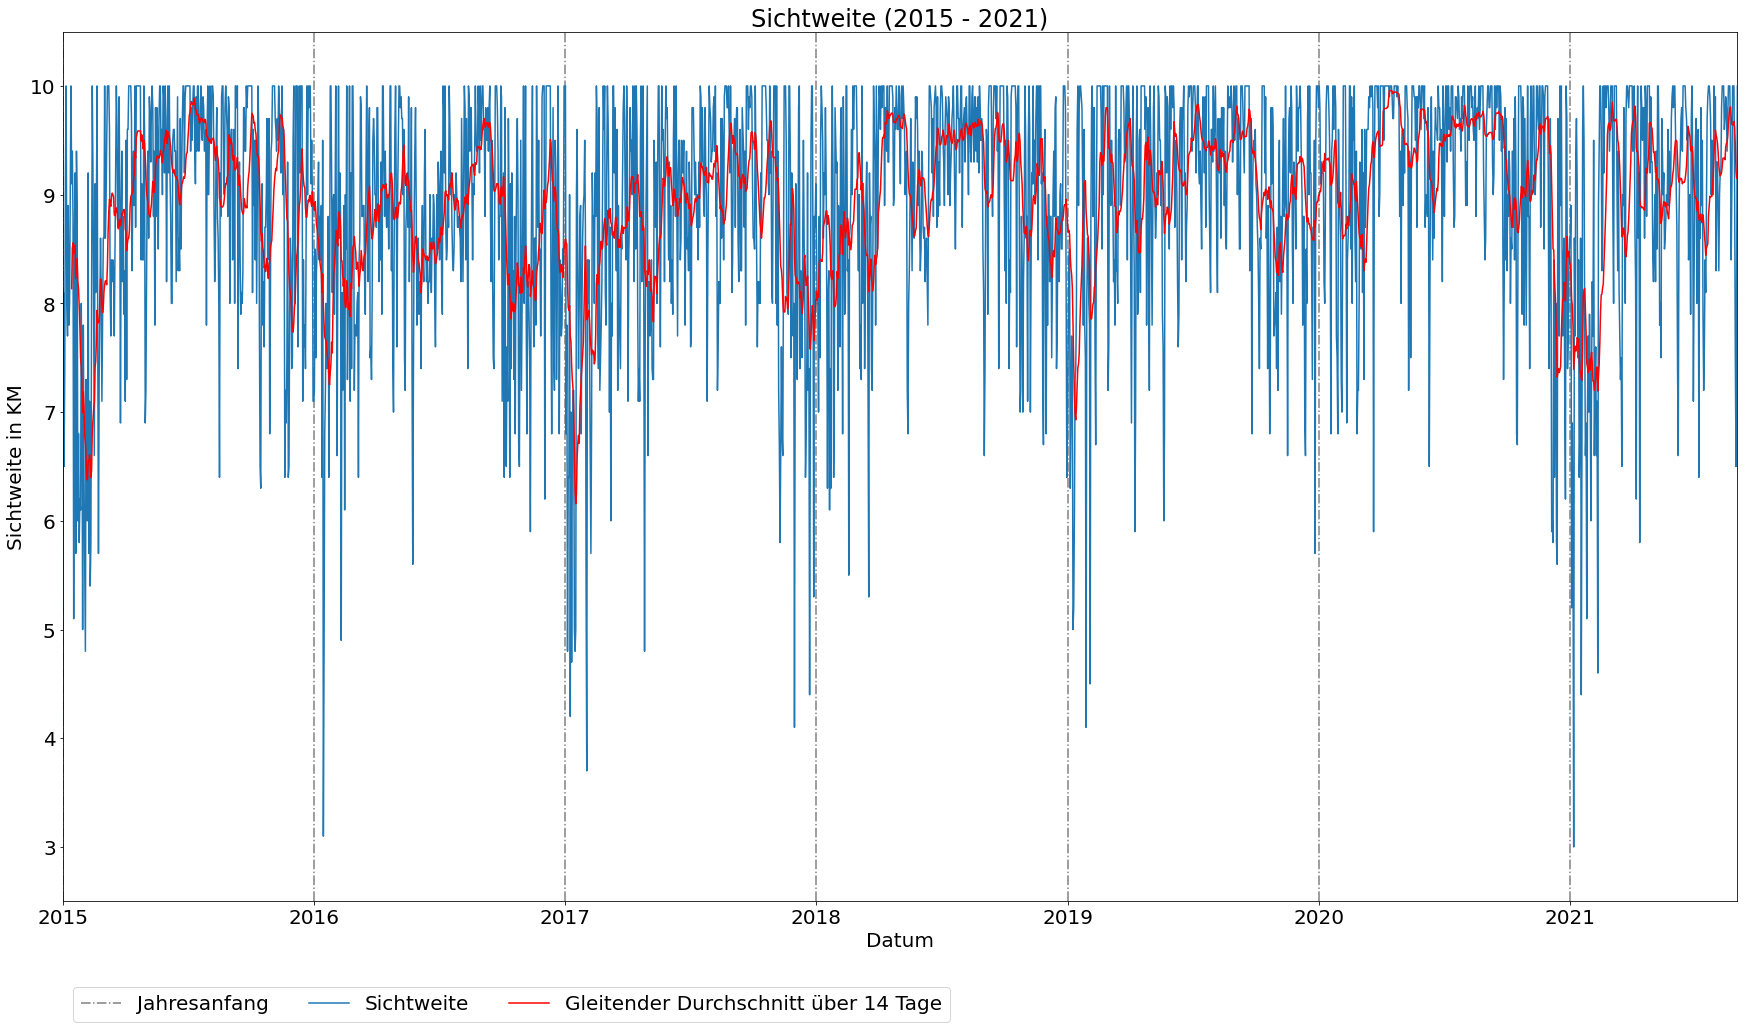

In [3]:
functions.draw_years(df)

#Sichtweite plotten
plt.plot(df["sichtweite"], label="Sichtweite");
plt.plot(df["sichtweite"].rolling(window=14).mean(), color="red", label="Gleitender Durchschnitt über 14 Tage")

#Achsen und Layout
plt.title("Sichtweite (2015 - 2021)")
plt.ylabel("Sichtweite in KM")
plt.ylim(2.5, 10.5)
plt.xlabel("Datum")
plt.xlim(dt.datetime(2015,1,1), dt.datetime(2021,8,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=4)

plt.show()

<a class="anchor" id="2-08b-nachmonaten"></a>

<font size="5">Die Saisonalität lässt sich auch an den Boxplots je Monat erkennen. Die Sichtweite ist im Durchschnitt gegen Mitte des Jahres sehr hoch und gegen Ende/Anfang des Jahres eher geringer.</font>

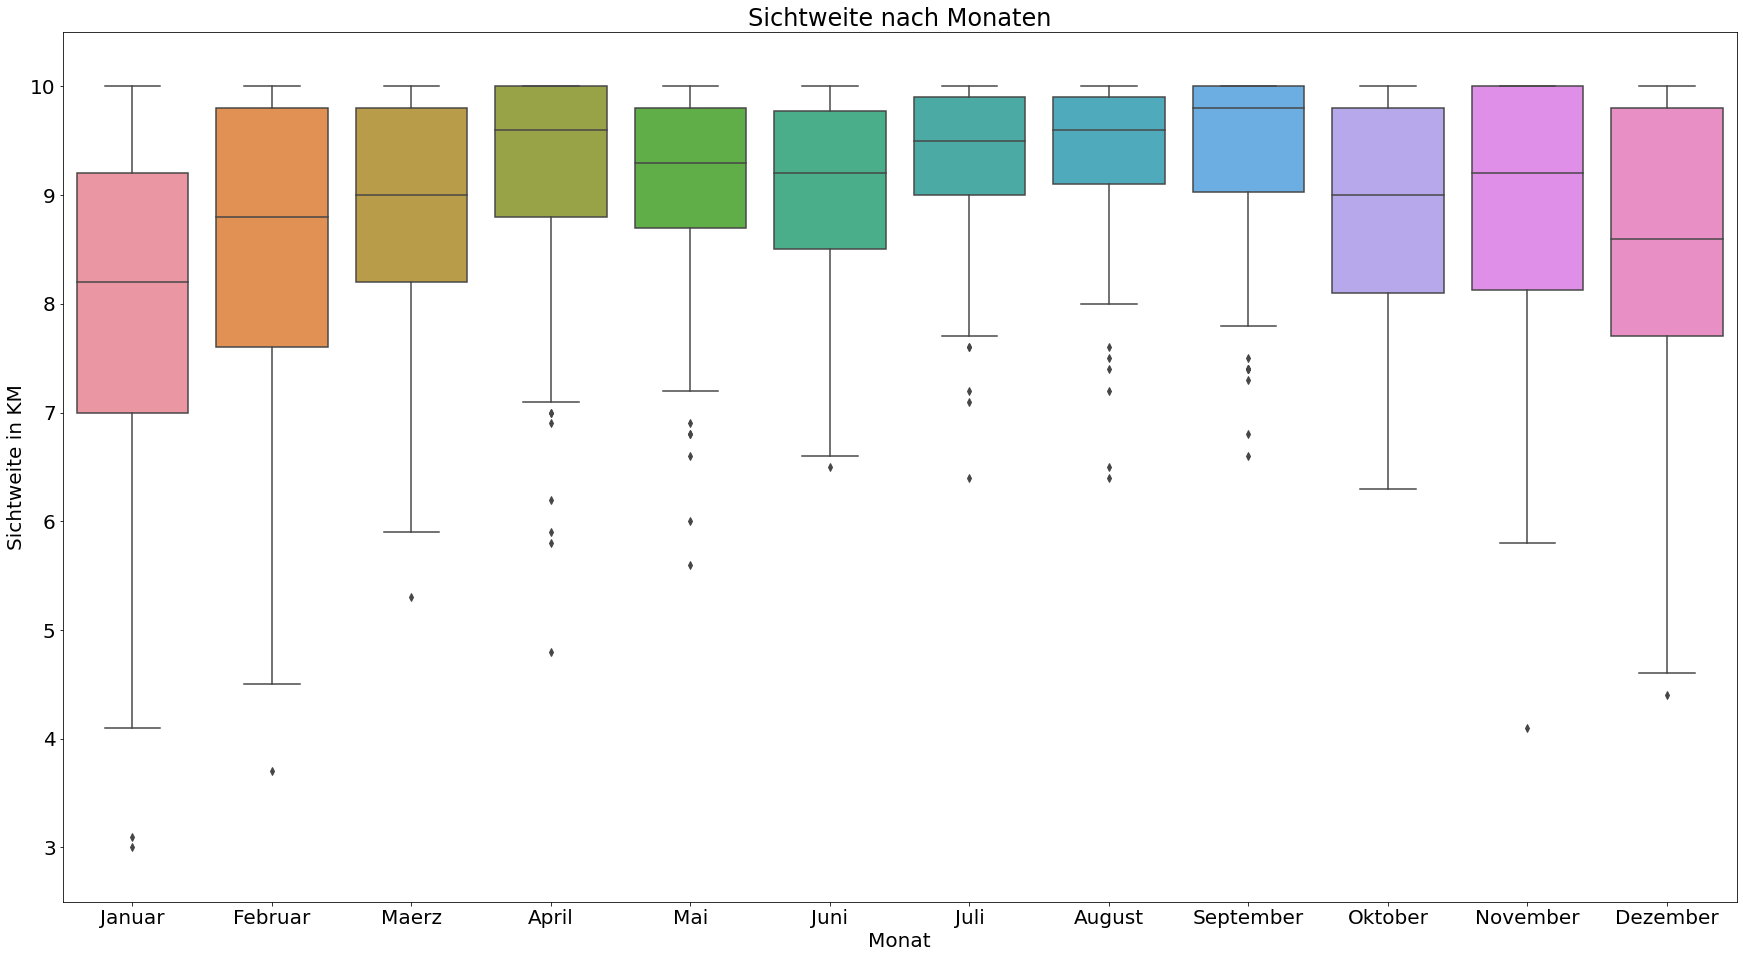

In [4]:
#Boxplot erstellen
sns.boxplot(data=df, x="monat", y="sichtweite")

#Achsen und Layout
plt.title("Sichtweite nach Monaten")
plt.ylabel("Sichtweite in KM")
plt.ylim(2.5, 10.5)
plt.xlabel("Monat")

plt.show()

<font size="5">Die Werte sind deutlich linksschief um den Mittelwert verteilt.</font>

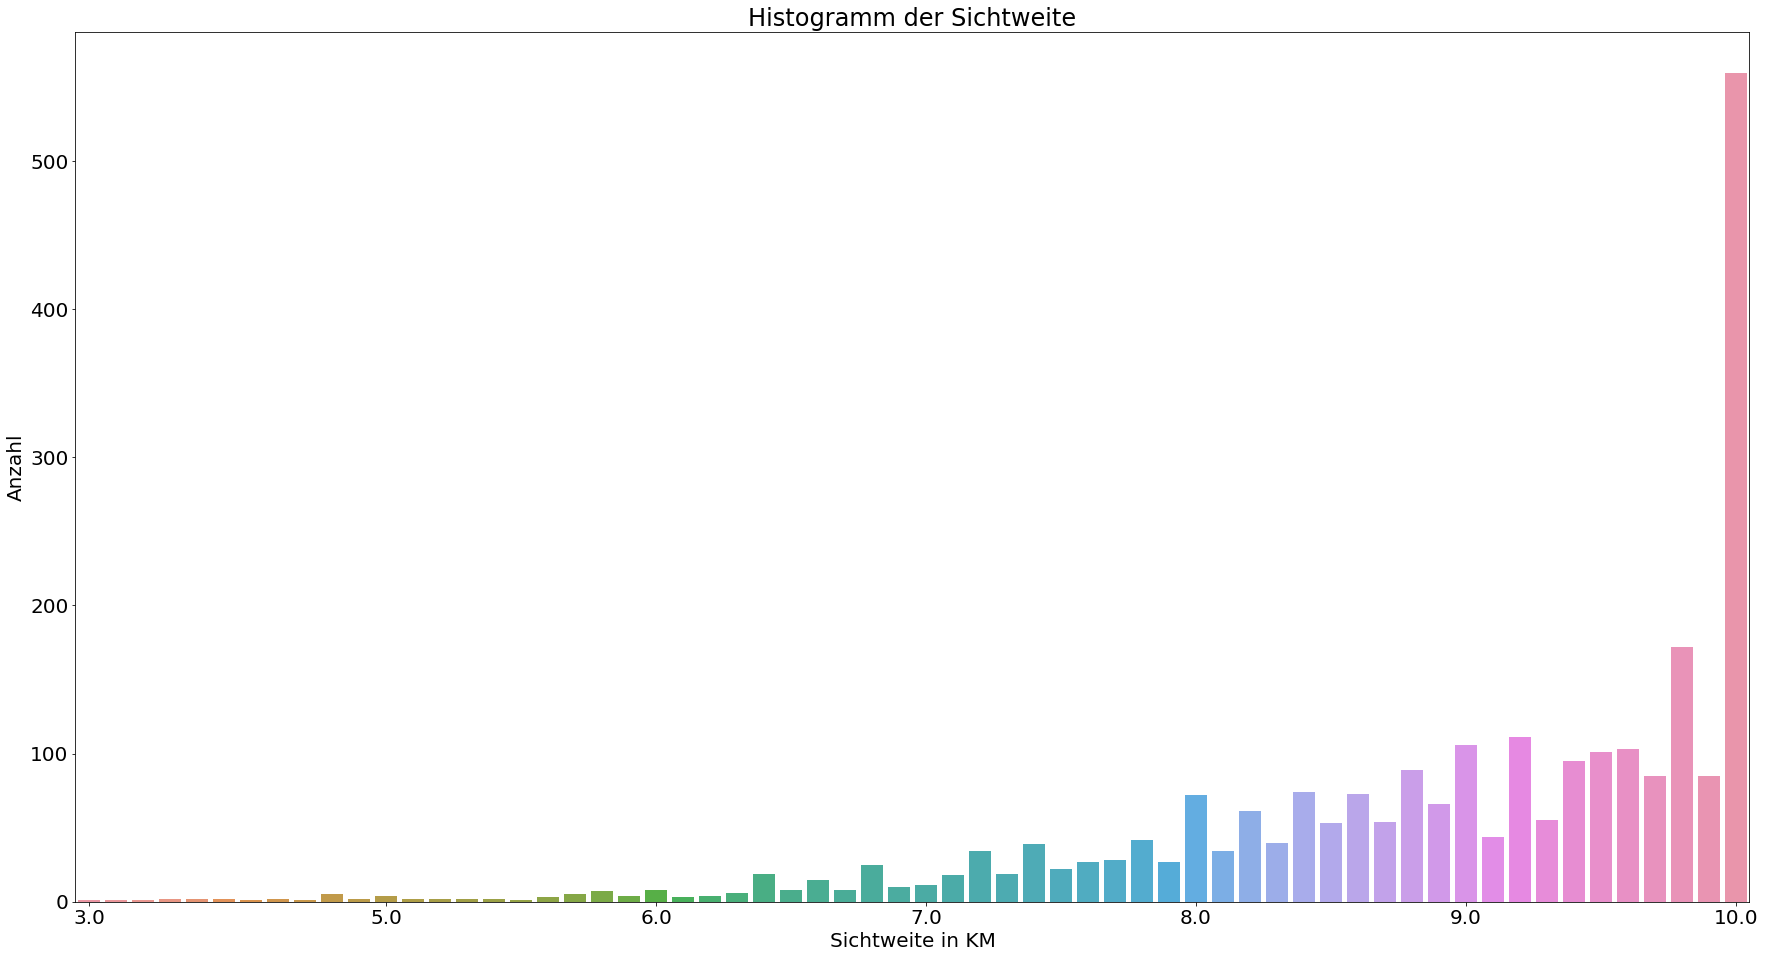

In [5]:
#Histogramm erstellen
sns.countplot(df["sichtweite"])

#Achsen und Layout
plt.title("Histogramm der Sichtweite")
plt.ylabel("Anzahl")
plt.xlabel("Sichtweite in KM")
plt.xticks([0,11,21,31,41,51,61])

plt.show()

# <font size="7">Korrelationsanalyse</font>

## <font size="6">Liniendiagramm (Verlauf)</font>

<font size="5">Es lässt sich zunächst ein Zusammenhang zwischen der Sichtweite und dem Stromverbrauch erkennen. Die Sichtweite ist im Sommer besonders hoch, im Winter hingegen eher geringer und verläuft daher dem Stromverbrauch entgegengesetzt. Das lokale Maximum des Stromverbrauchs in der Mitte des Jahres lässt sich allerdings nicht durch das Merkmal erklären. Besonders deutlich wird dies beim Betrachten der gleitenden Durchschnitte.</font>

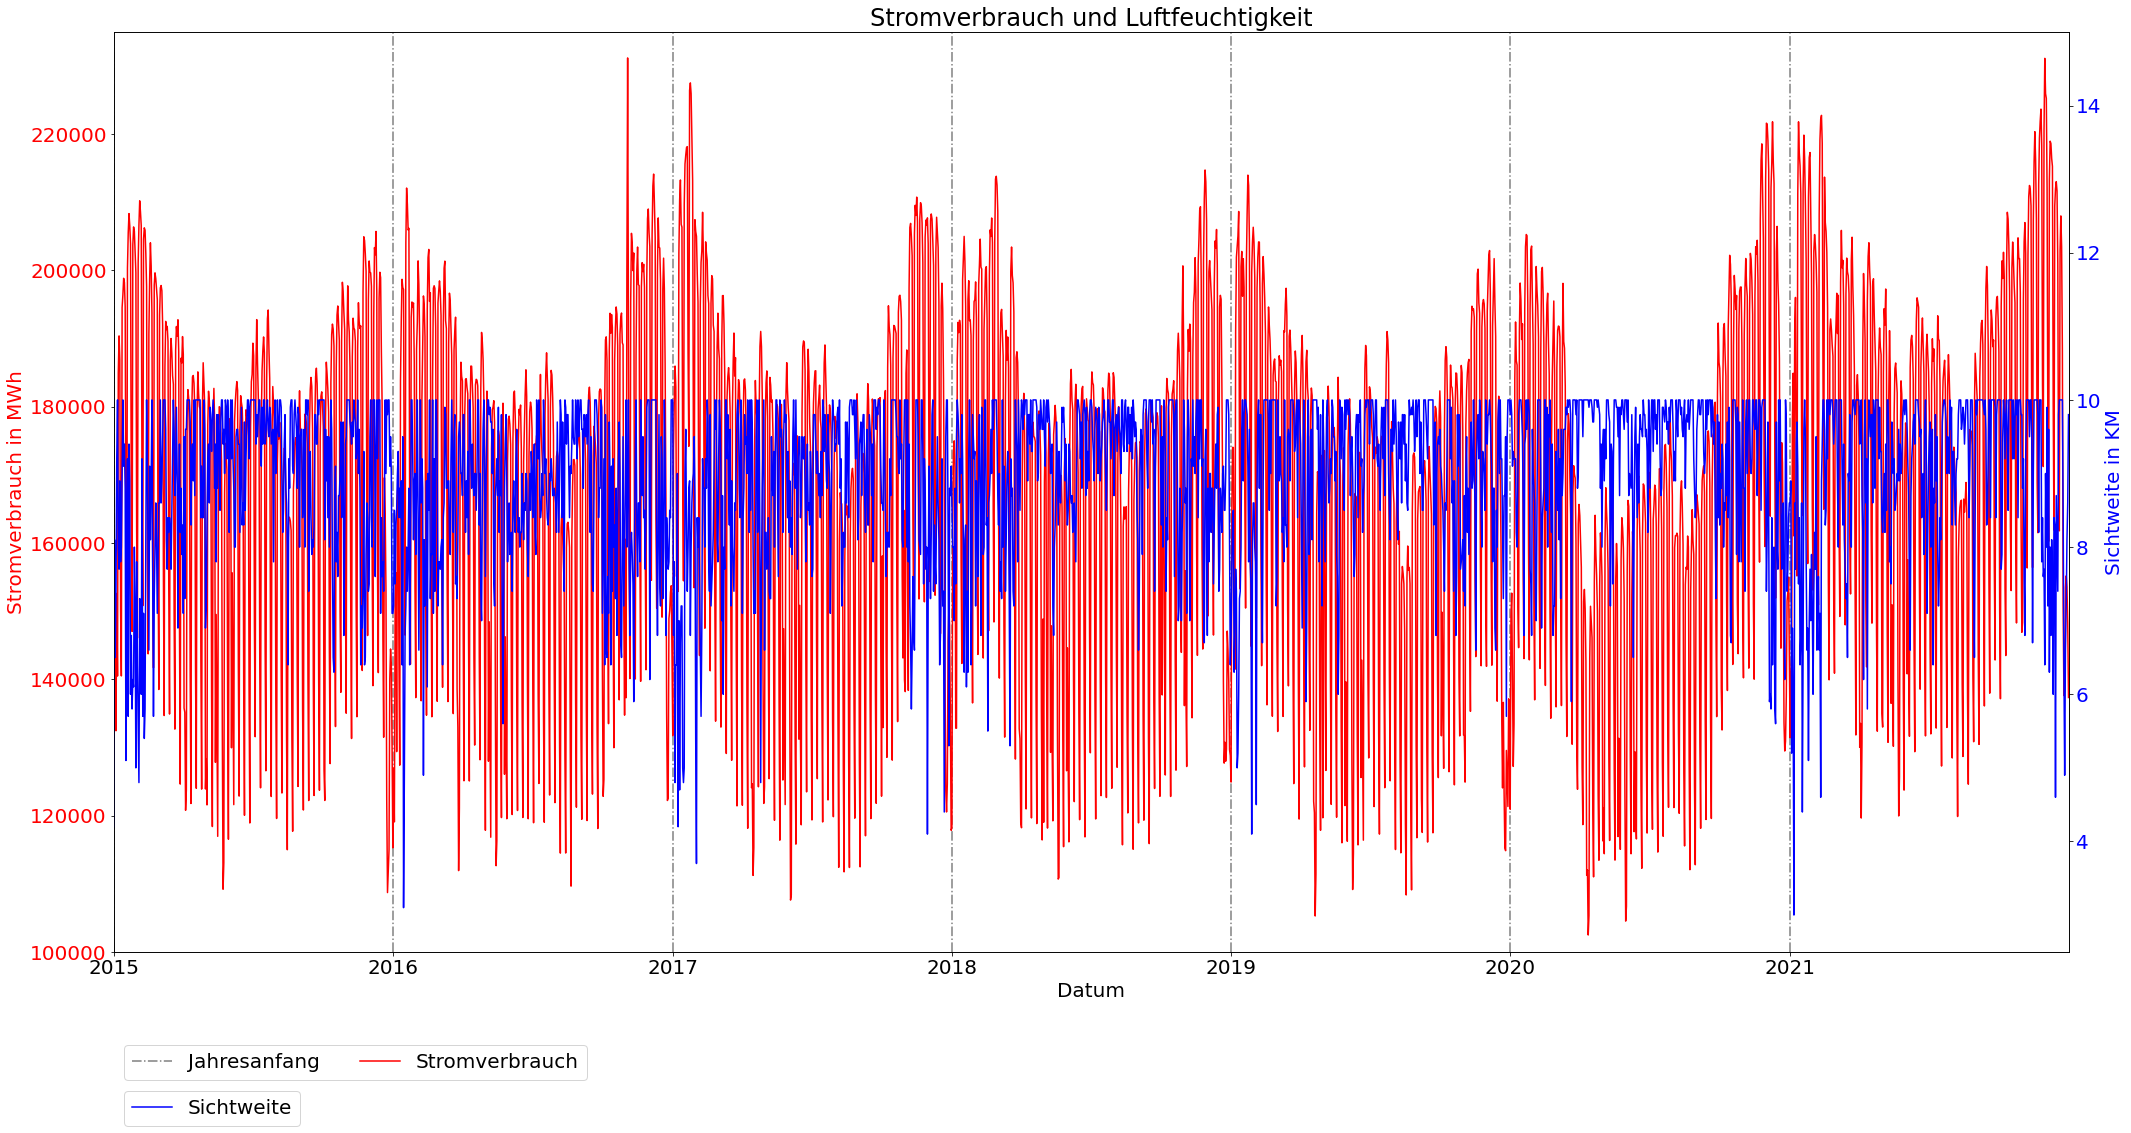

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.148
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.141
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.099





In [6]:
fig, ax1 = plt.subplots()

functions.draw_years(df)

ax1.set_title("Stromverbrauch und Luftfeuchtigkeit")

#Verbrauch plotten
ax1.plot(df["verbrauch"], color="red", label="Stromverbrauch")
#Achsen und Layout
ax1.set_ylabel("Stromverbrauch in MWh", color="red")
ax1.tick_params(axis="y", labelcolor="red")
ax1.set_ylim(100000,235000)
ax1.set_xlabel("Datum")
ax1.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=4)

ax2 = ax1.twinx()
#Sichtweite plotten
ax2.plot(df["sichtweite"], color="blue", label="Sichtweite")
#Achsen und Layout
ax2.set_ylabel("Sichtweite in KM", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.set_ylim(2.5, 15)
ax2.set_xlabel("Datum")
ax2.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

plt.tight_layout()
plt.show()

#Korrelationskoeffizienten ausgeben
functions.correlation_coefficients(df["sichtweite"], df["verbrauch"])
print("\n\n")

<a class="anchor" id="08-liniendiagrammdurchschnitt"></a>



 Gleitender Durchschnitt über 3  Tage----------------------------------------------------------------------------------------------------------------------------------------------




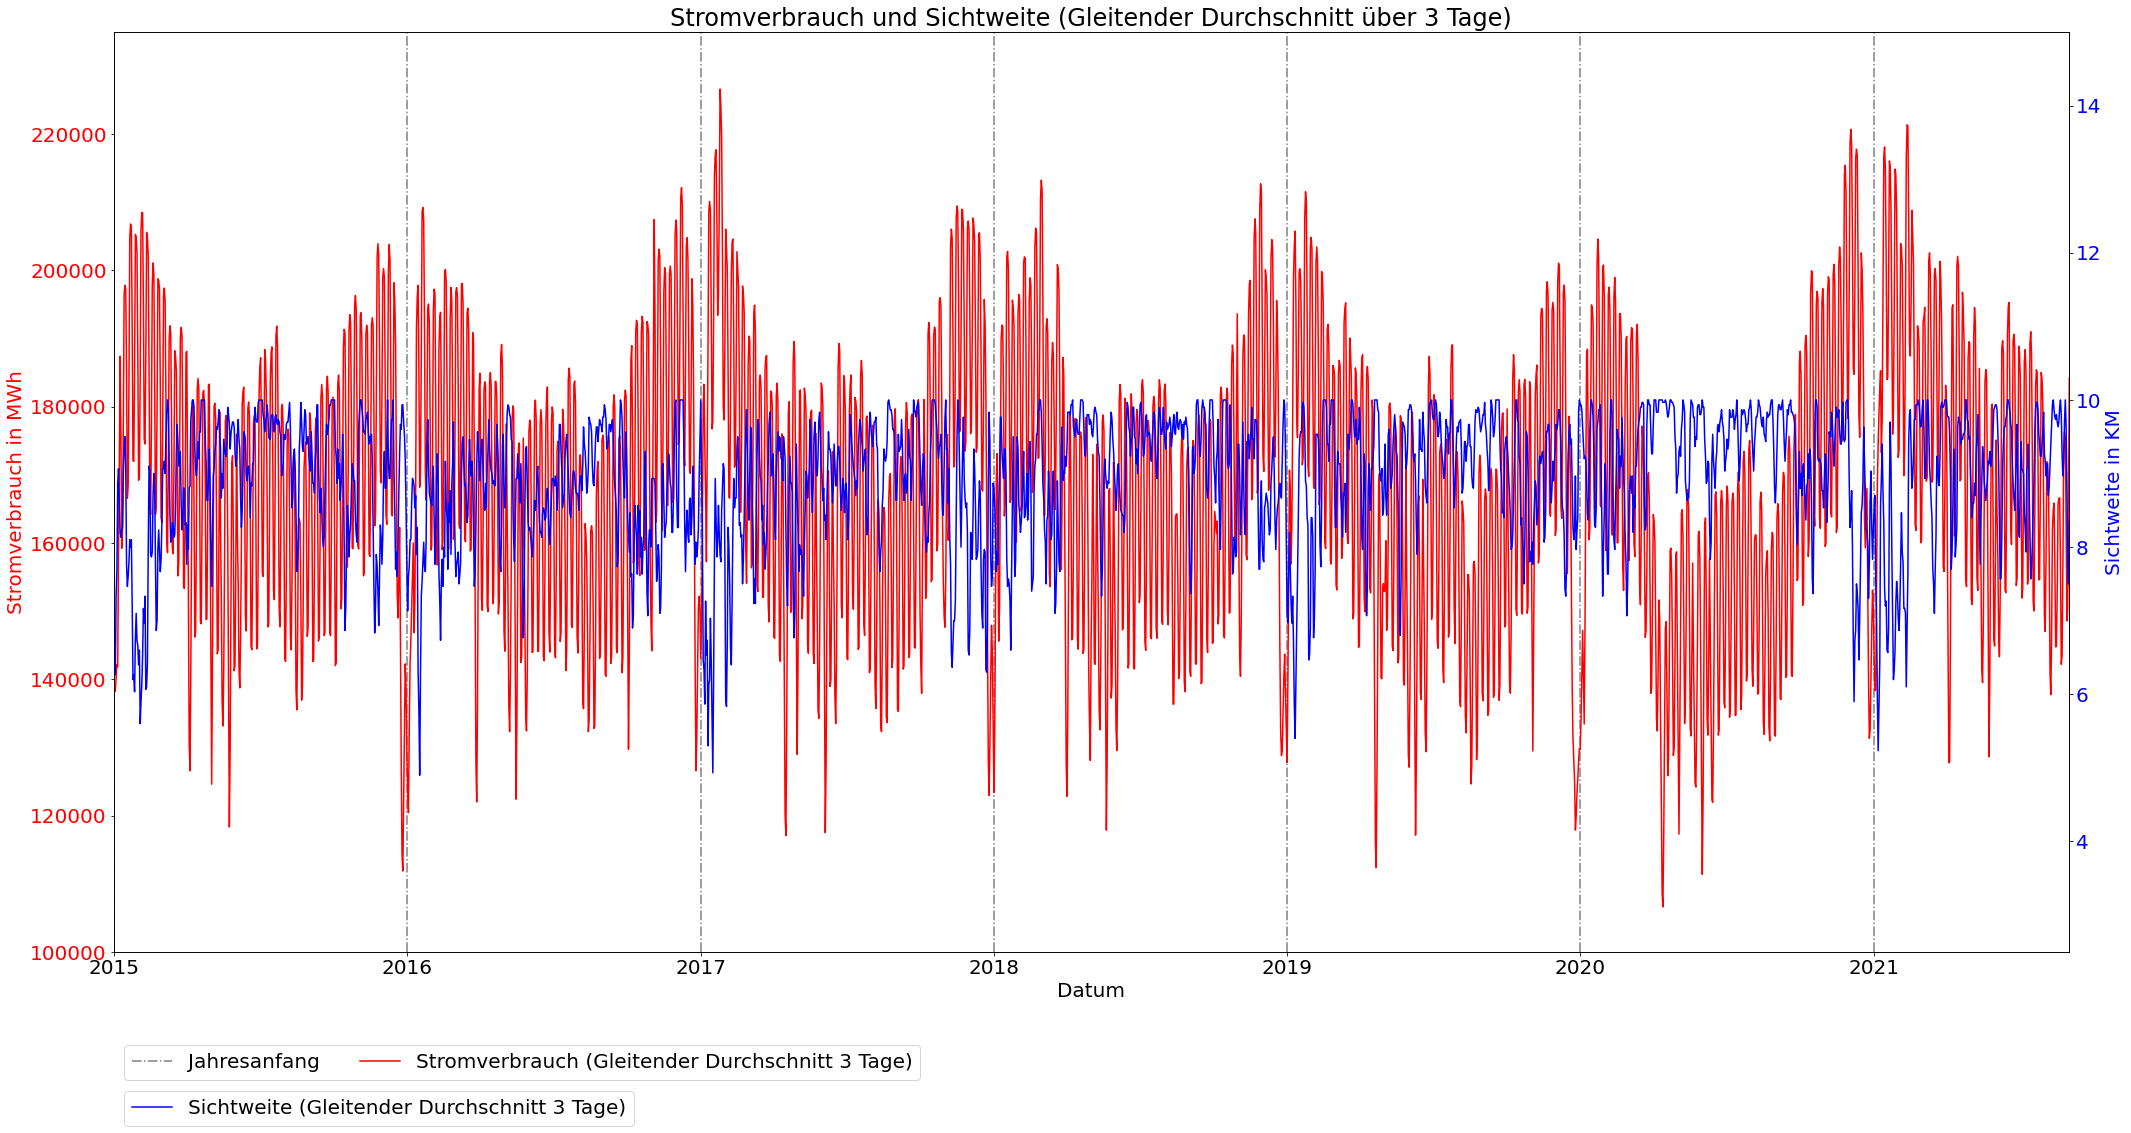

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.228
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.2
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.135





 Gleitender Durchschnitt über 7  Tage----------------------------------------------------------------------------------------------------------------------------------------------




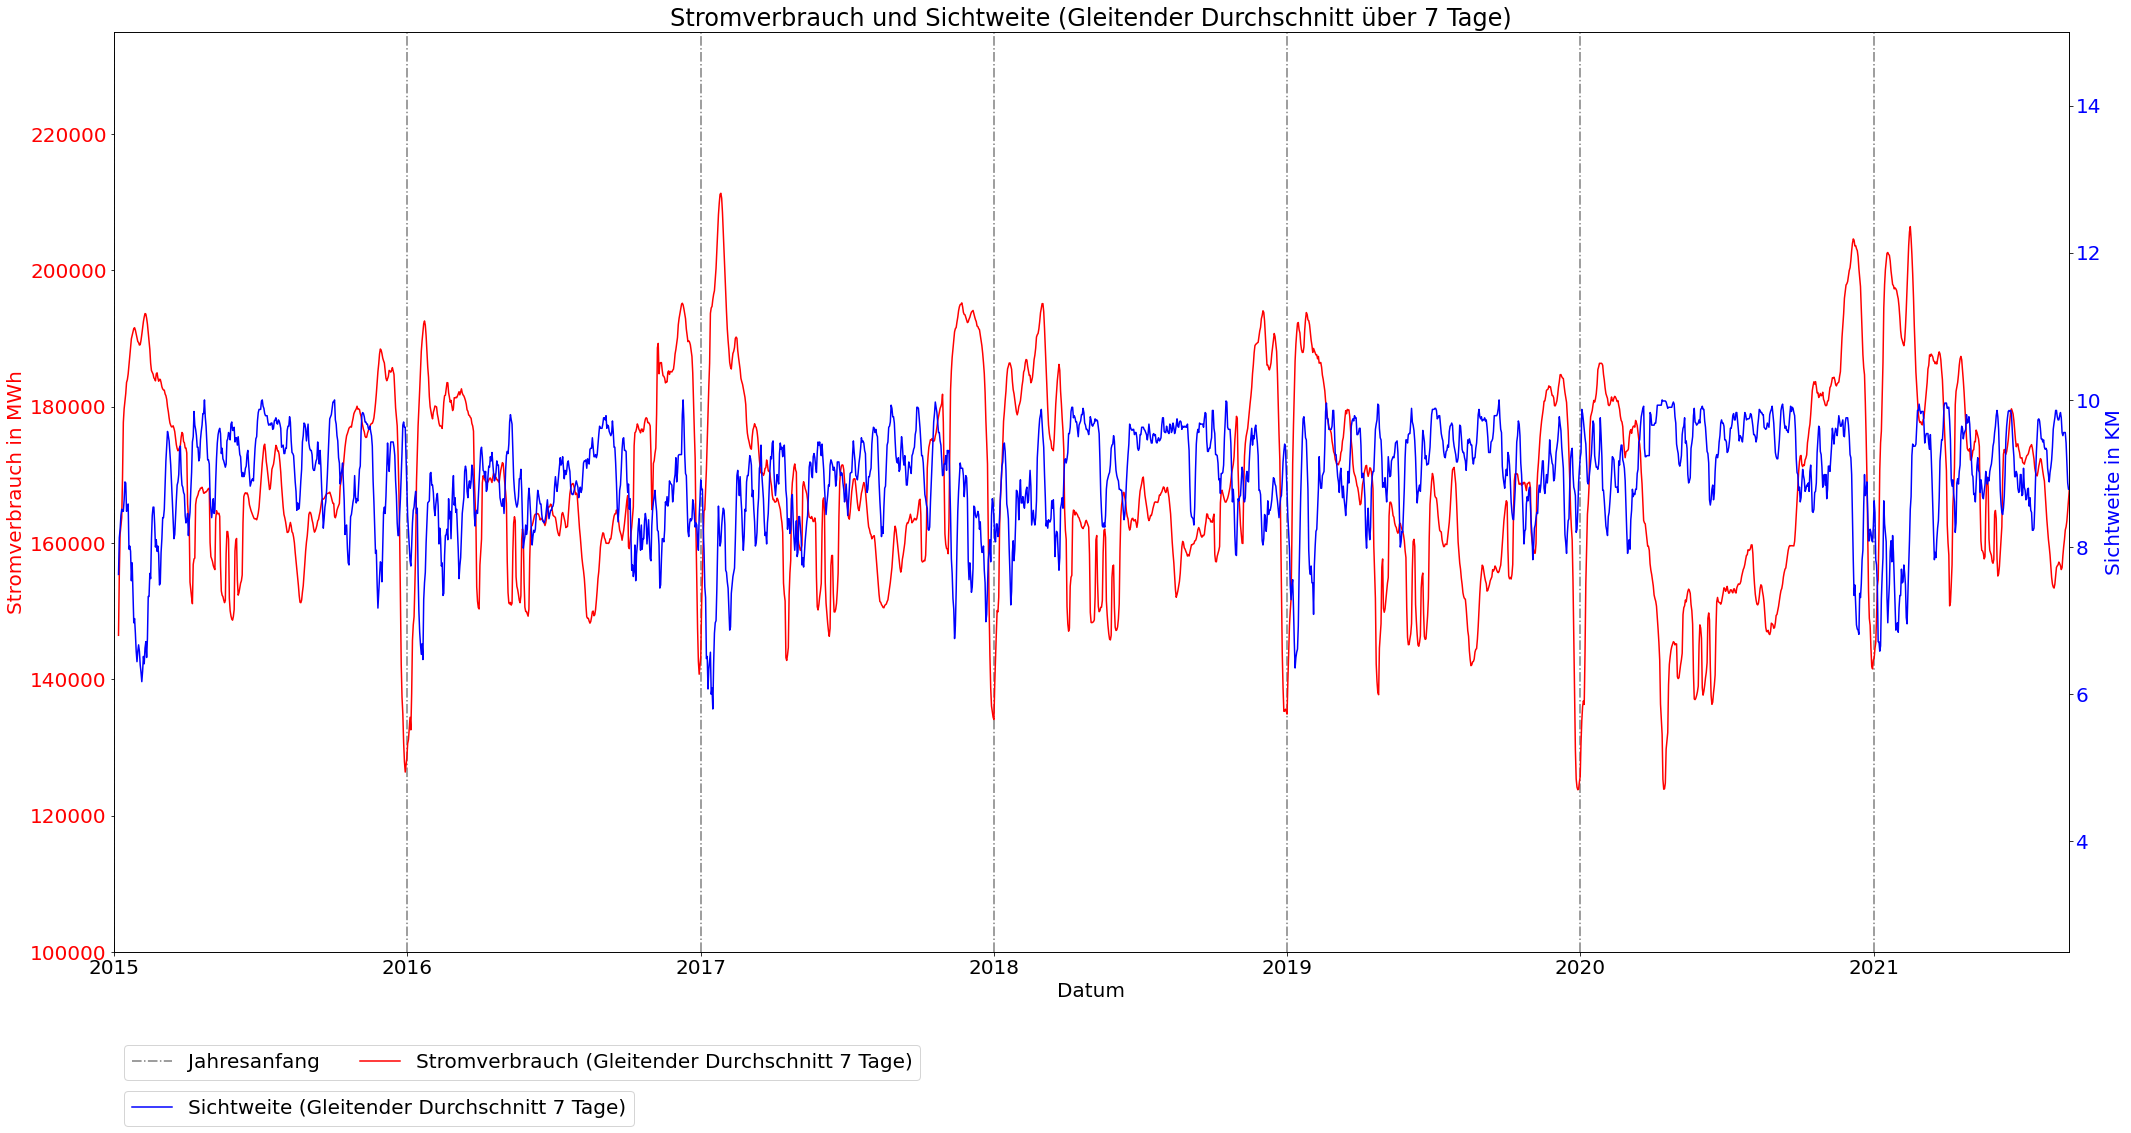

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.382
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.347
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.243





 Gleitender Durchschnitt über 14  Tage----------------------------------------------------------------------------------------------------------------------------------------------




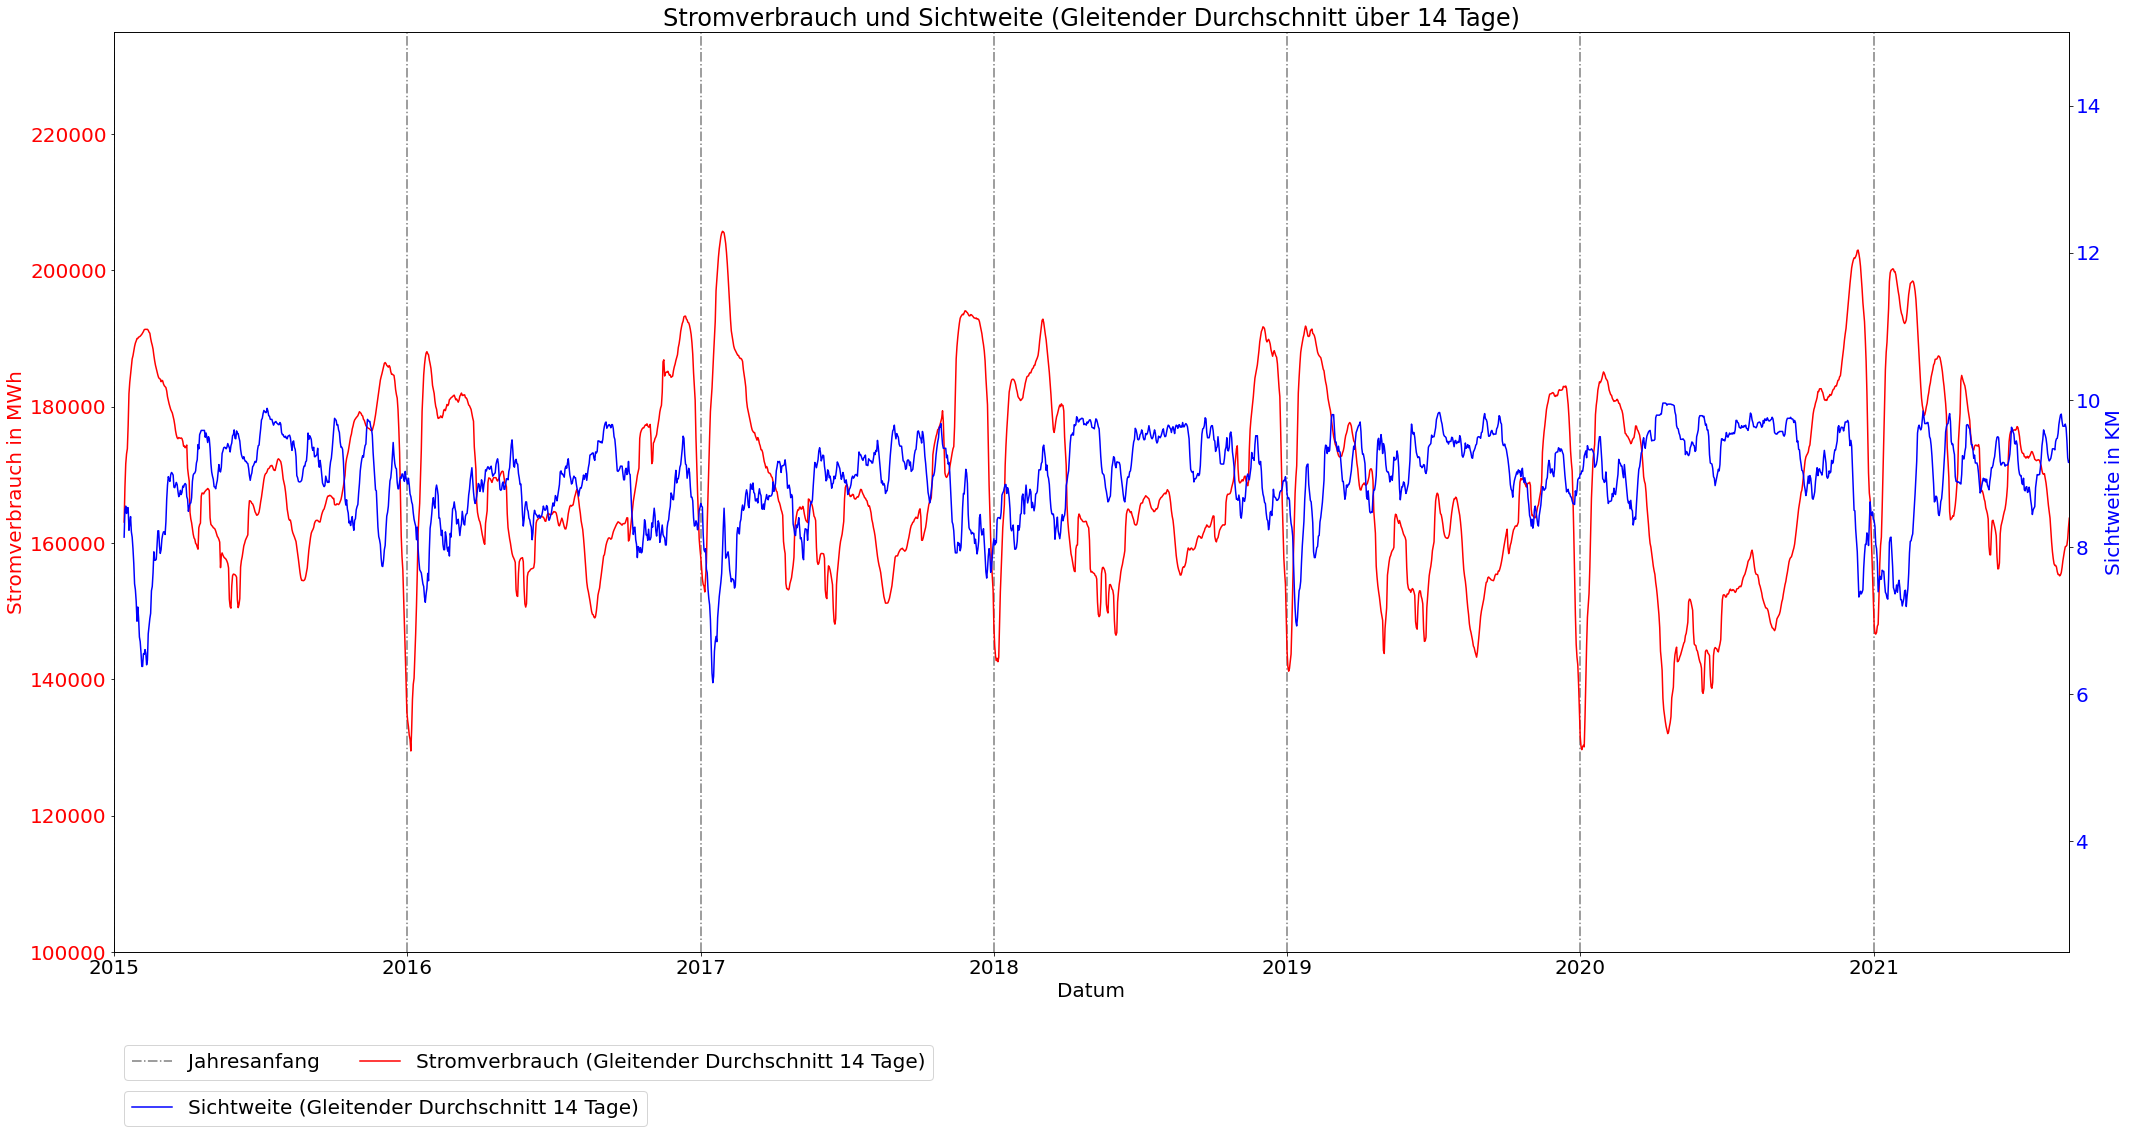

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.451
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.418
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.295





 Gleitender Durchschnitt über 28  Tage----------------------------------------------------------------------------------------------------------------------------------------------




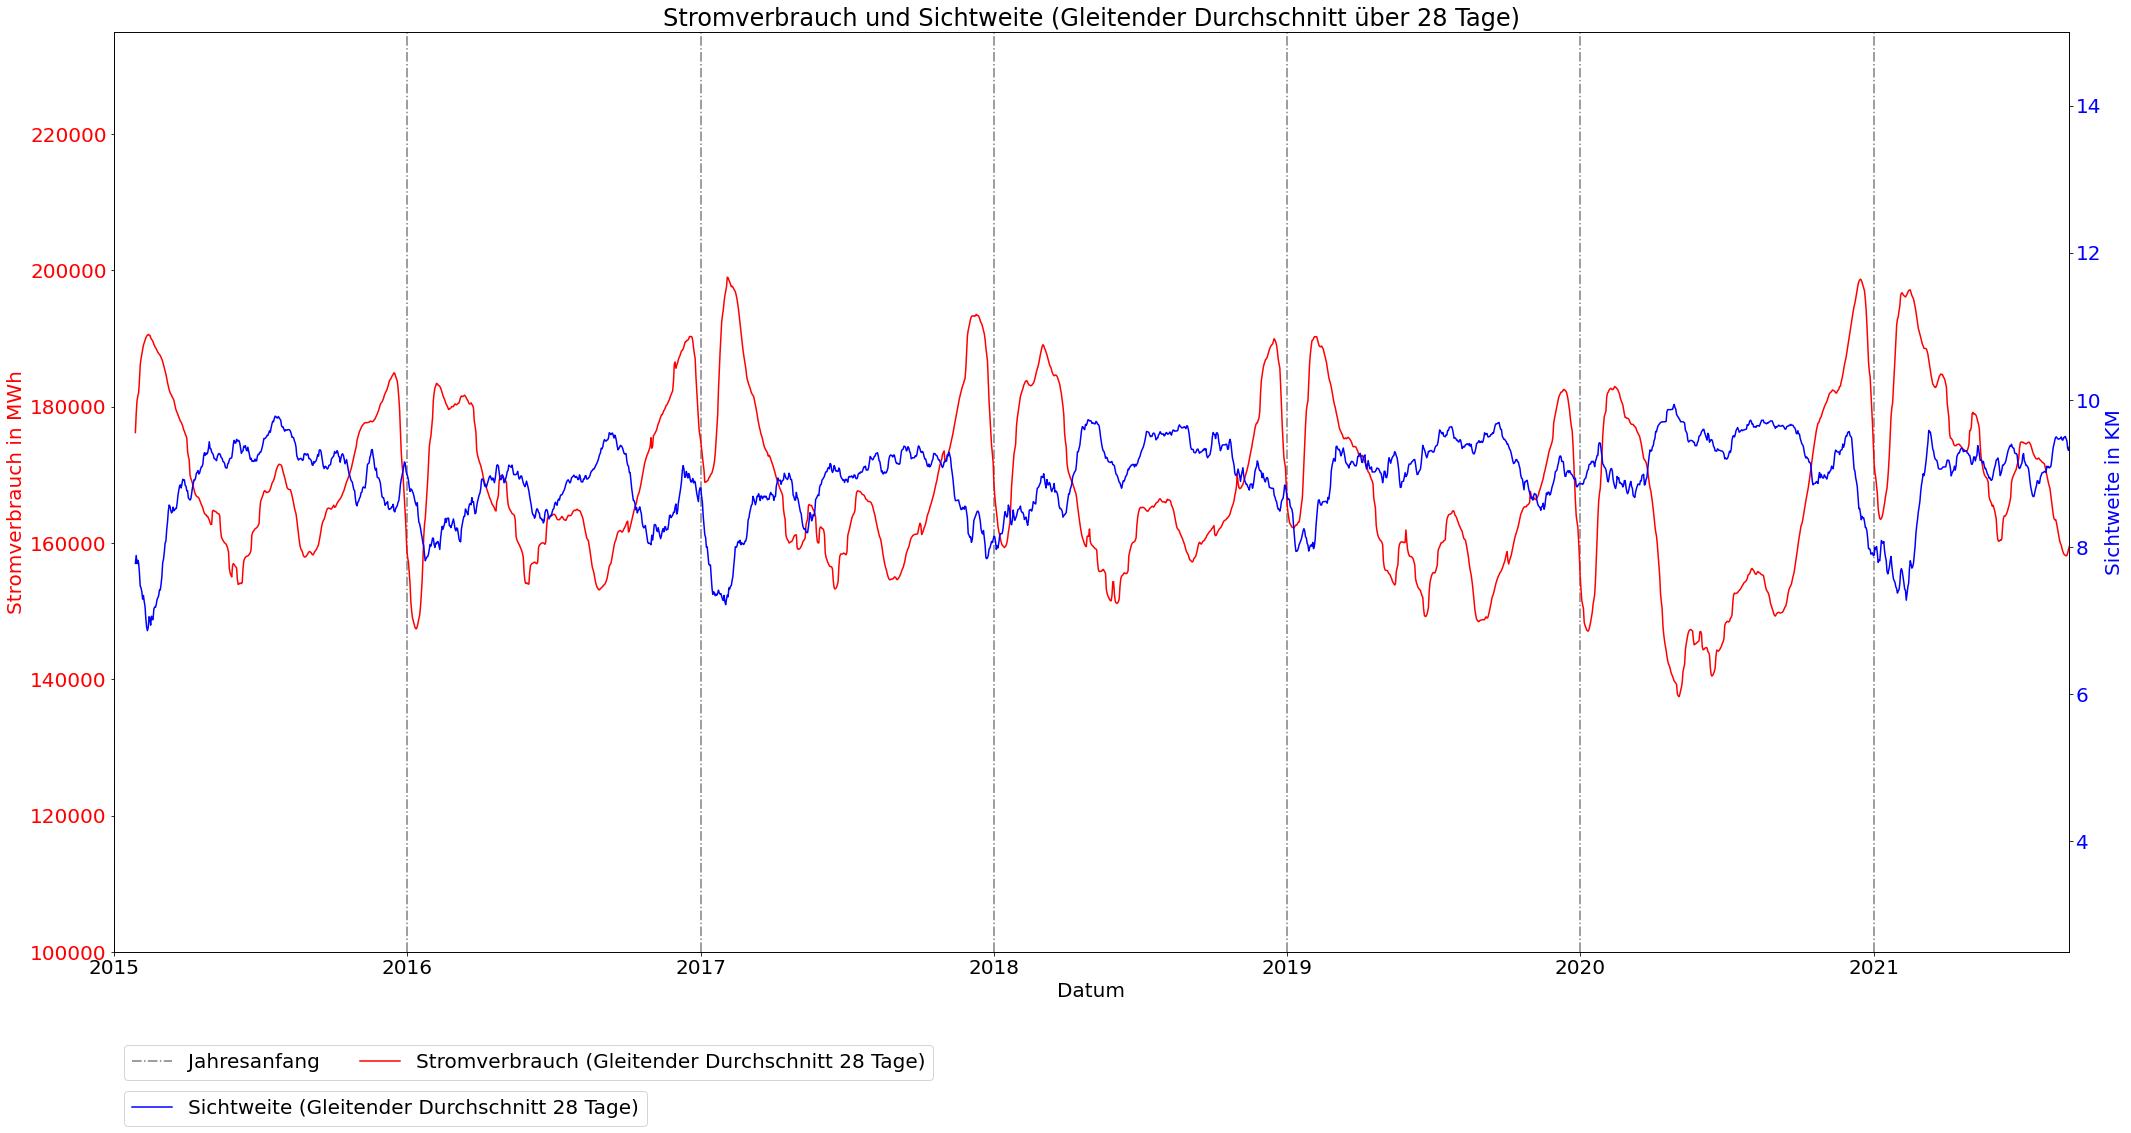

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.526
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.51
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.361





In [7]:
#Durchlaufen verschiedener gleitender Durchschnitte
for window in [3, 7, 14, 28]:

    print("\n\n", "Gleitender Durchschnitt über", window," Tage----------------------------------------------------------------------------------------------------------------------------------------------\n\n")
    
    fig, ax1 = plt.subplots()

    functions.draw_years(df)

    ax1.set_title("Stromverbrauch und Sichtweite (Gleitender Durchschnitt über " + str(window) + " Tage)")
    
    #Gleitenden Durchschnitt des Verbrauchs plotten
    ax1.plot(df["verbrauch"].rolling(window=window).mean(), color="red", label="Stromverbrauch (Gleitender Durchschnitt " + str(window) + " Tage)")
    #Achsen und Layout
    ax1.set_ylabel("Stromverbrauch in MWh", color="red")
    ax1.tick_params(axis="y", labelcolor="red")
    ax1.set_ylim(100000,235000)
    ax1.set_xlabel("Datum")
    ax1.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,8,31))

    #Legende einfügen
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=4)
    
    #Gleitenden Durchschnitt der Sichtweite plotten
    ax2 = ax1.twinx()
    ax2.plot(df["sichtweite"].rolling(window=window).mean(), color="blue", label="Sichtweite (Gleitender Durchschnitt " + str(window) + " Tage)")
    #Achsen und Layout
    ax2.set_ylabel("Sichtweite in KM", color="blue")
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.set_ylim(2.5, 15)
    ax2.set_xlabel("Datum")
    ax2.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,8,31))

    #Legende einfügen
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

    plt.tight_layout()
    plt.show()

    #Korrelationskoeffizienten ausgeben
    functions.correlation_coefficients(df["sichtweite"].rolling(window=window).mean().dropna(), df["verbrauch"].rolling(window=window).mean().dropna())
    print("\n\n")

## <font size="6">Stromverbrauch nach Sichtweite (Scatterplot)</font>

<font size="5">Im Scatterplot lässt sich zwar kein Zusammenhang erkennen, die Regressionsfunktionen deuten aber auch einen Zusammenhang beziehungsweise eine negative Korrelation der Merkmale hin. Dabei ist allerdings zu beachten, dass das Merkmal nach oben hin auf maximal 10 km begrenzt ist.</font>

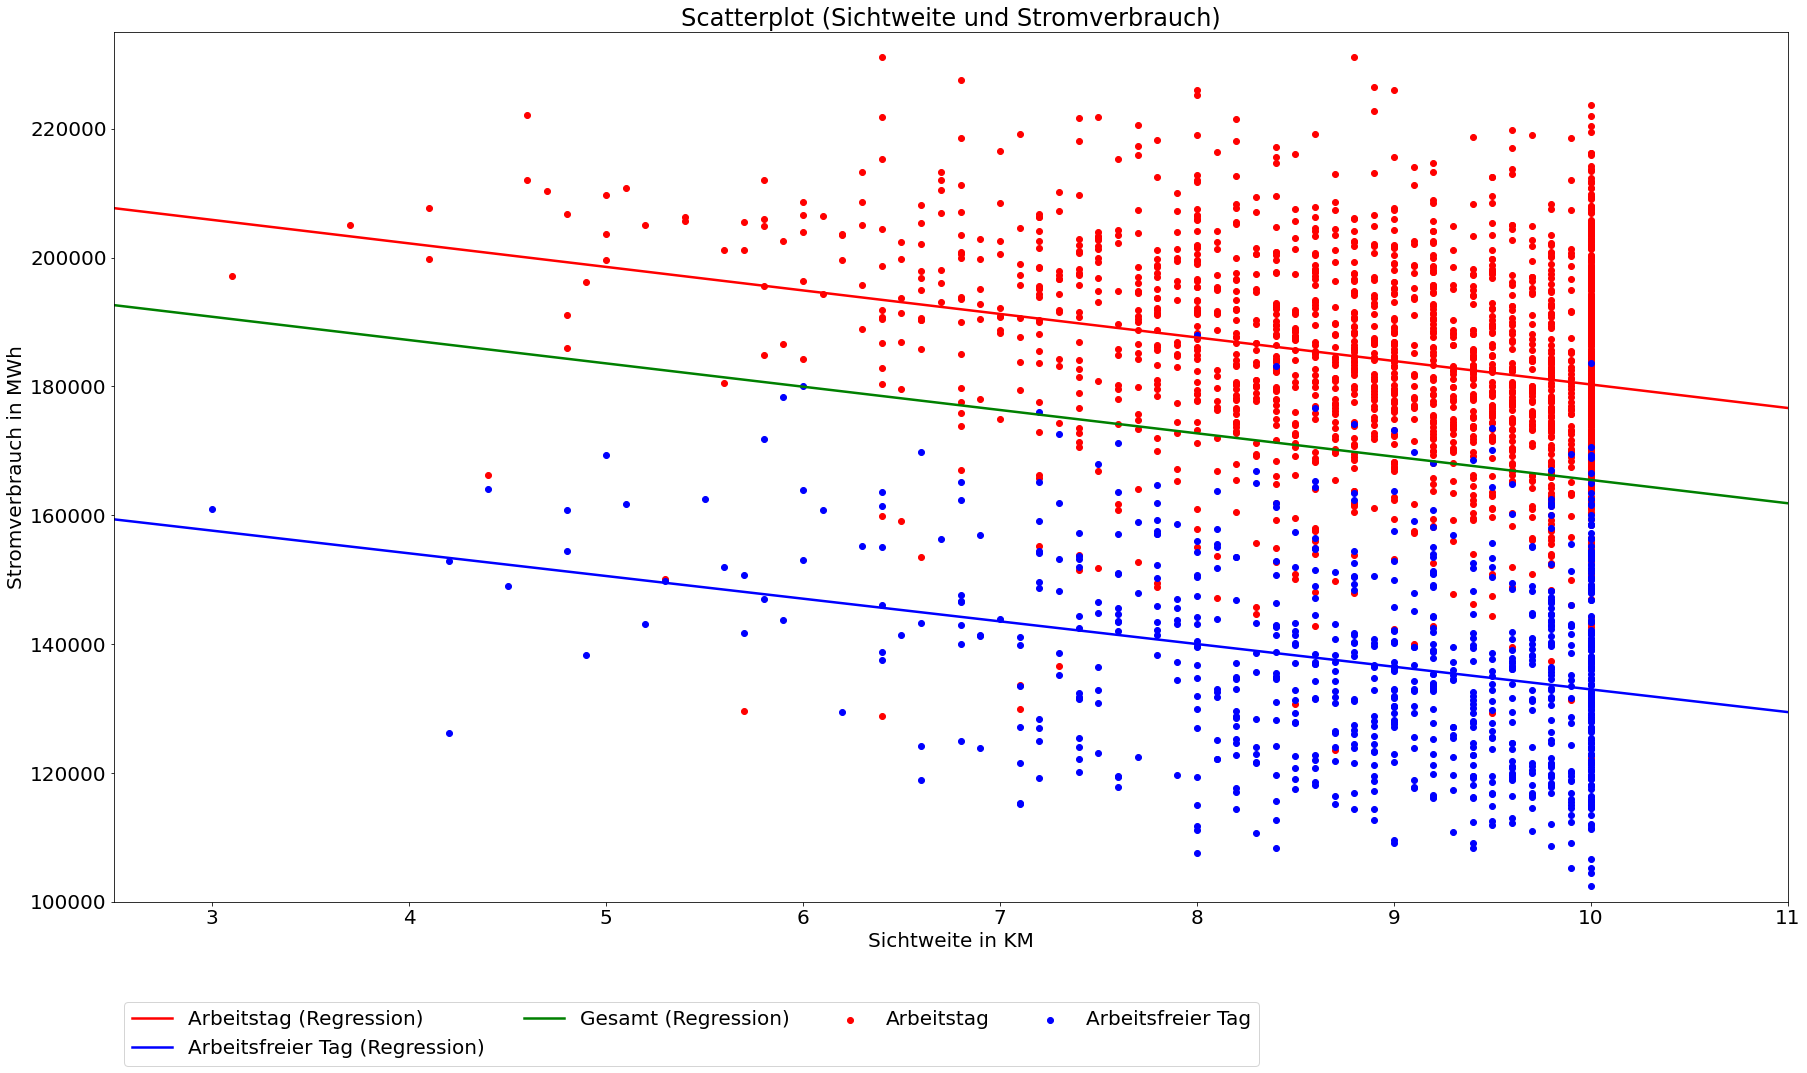

Arbeitstage
Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.554
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.635
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.462


Arbeitsfreie Tage
Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.558
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.55
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.38


In [8]:
x = range(2, 12, 1)

#Sichtweite und Verbrauch an Arbeitstagen plotten
plt.scatter(df_arbeitstag["sichtweite"], df_arbeitstag["verbrauch"], color="red", label="Arbeitstag")
#Steigung und Intercept für Regression bilden
m1, b1 = np.polyfit(df_arbeitstag["sichtweite"], df_arbeitstag["verbrauch"], 1)
#Regressionsfunktion einzeichnen
plt.plot(x, m1 * x + b1, color="red", linewidth=2.5, label="Arbeitstag (Regression)")

#Sichtweite und Verbrauch an arbeitsfreien Tagen plotten
plt.scatter(df_arbeitsfreiertag["sichtweite"], df_arbeitsfreiertag["verbrauch"], color="blue", label="Arbeitsfreier Tag")
#Steigung und Intercept für Regression bilden
m2, b2 = np.polyfit(df_arbeitsfreiertag["sichtweite"], df_arbeitsfreiertag["verbrauch"], 1)
#Regressionsfunktion einzeichnen
plt.plot(x, m2 * x + b2, color="blue", linewidth=2.5, label="Arbeitsfreier Tag (Regression)")

#Steigung und Intercept für Regression mit allen Tagen bilden
m3, b3 = np.polyfit(df["sichtweite"], df["verbrauch"], 1)
#Regressionsfunktion einzeichnen
plt.plot(x, m3 * x + b3, color="green", linewidth=2.5, label="Gesamt (Regression)")

#Achsen und Layout
plt.title("Scatterplot (Sichtweite und Stromverbrauch)")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000, 235000)
plt.xlabel("Sichtweite in KM")
plt.xlim(2.5, 11)

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

plt.show()

#Korrelationskoeffizienten ausgeben
print("Arbeitstage")
functions.correlation_coefficients(df_arbeitstag["temperatur"], df_arbeitstag["verbrauch"])
print("\n\nArbeitsfreie Tage")
functions.correlation_coefficients(df_arbeitsfreiertag["temperatur"], df_arbeitsfreiertag["verbrauch"])

<font size="5">Wenn die eher seltenen Tage mit einer Sichtweite von weniger als 8 km entfernt werden, kann allerdings auch die Regressionsfunktion keinen Zusammenhang mehr ermitteln.</font>

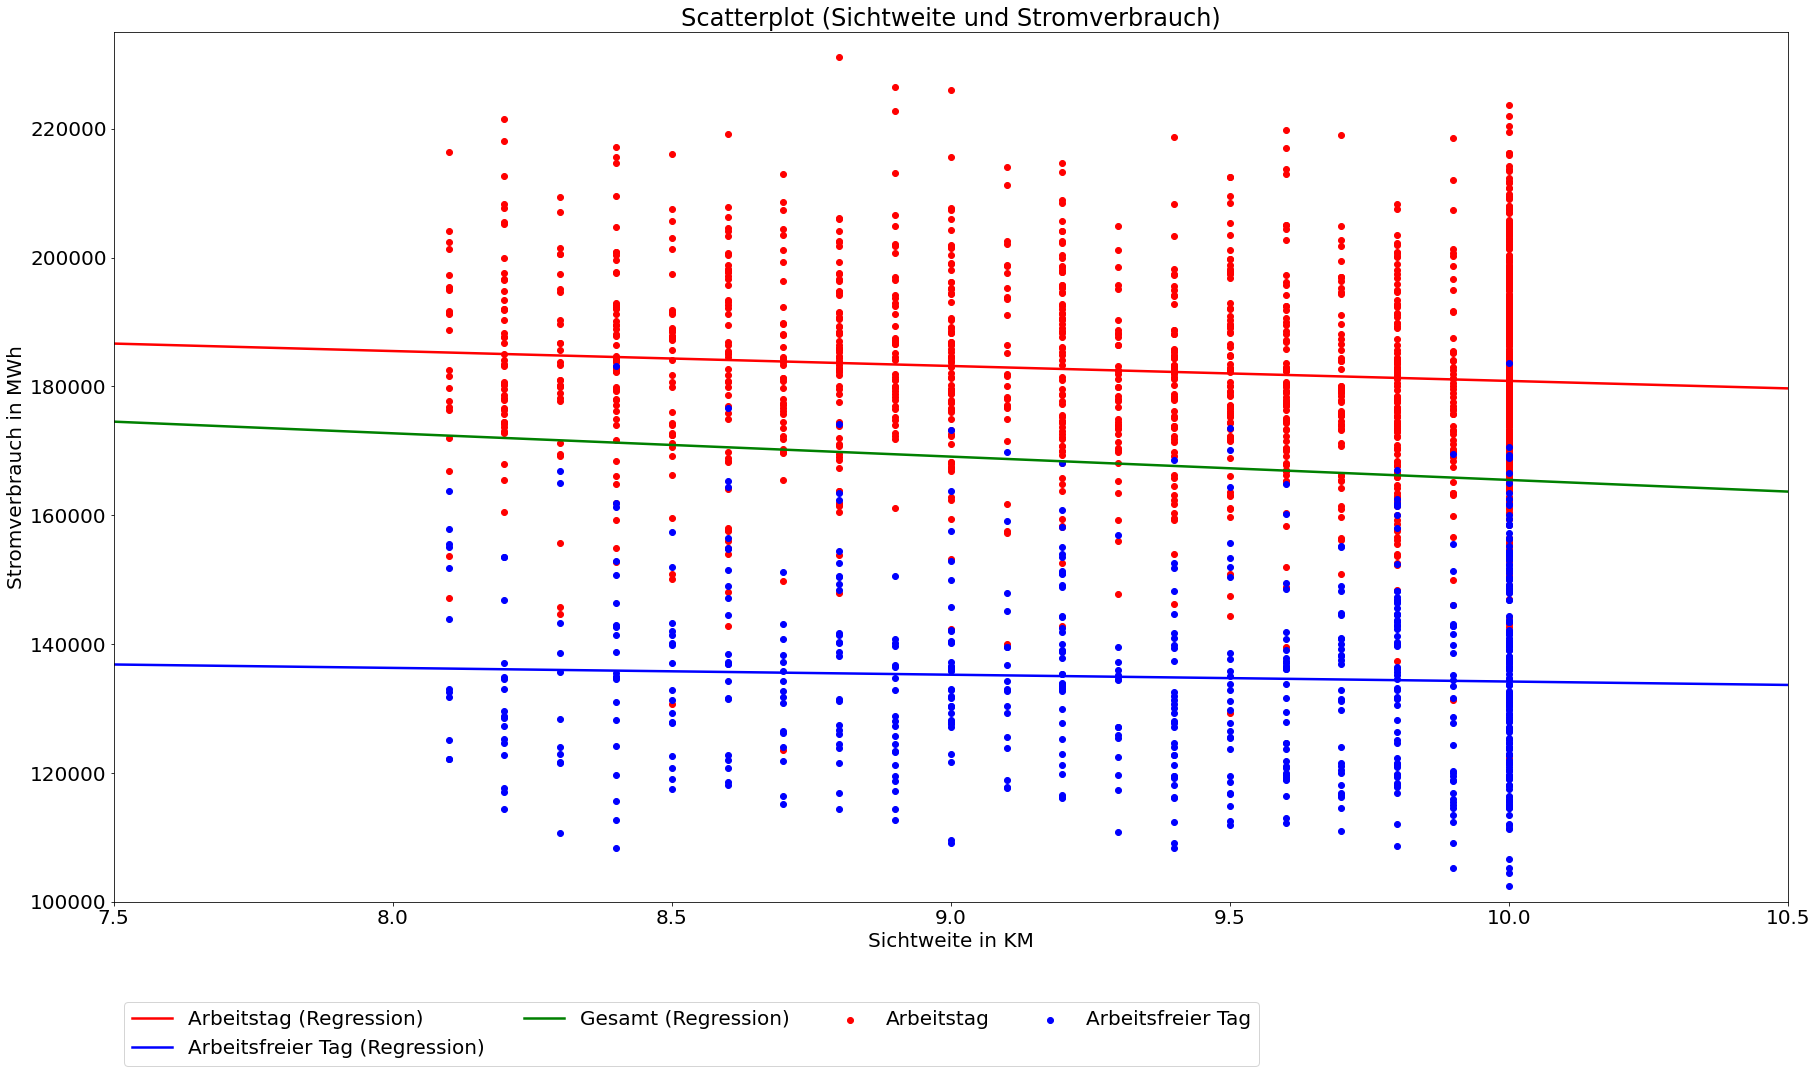

Arbeitstage
Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.522
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.578
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.415


Arbeitsfreie Tage
Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.509
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.465
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.321


In [9]:
x = range(2, 12, 1)

df_arbeitstag_ = df_arbeitstag[df_arbeitstag["sichtweite"] > 8]
df_arbeitsfreiertag_ = df_arbeitsfreiertag[df_arbeitsfreiertag["sichtweite"] > 8]

#Sichtweite und Verbrauch an Arbeitstagen plotten
plt.scatter(df_arbeitstag_["sichtweite"], df_arbeitstag_["verbrauch"], color="red", label="Arbeitstag")
#Steigung und Intercept für Regression bilden
m1, b1 = np.polyfit(df_arbeitstag_["sichtweite"], df_arbeitstag_["verbrauch"], 1)
#Regressionsfunktion einzeichnen
plt.plot(x, m1 * x + b1, color="red", linewidth=2.5, label="Arbeitstag (Regression)")

#Sichtweite und Verbrauch an arbeitsfreien Tagen plotten
plt.scatter(df_arbeitsfreiertag_["sichtweite"], df_arbeitsfreiertag_["verbrauch"], color="blue", label="Arbeitsfreier Tag")
#Steigung und Intercept für Regression bilden
m2, b2 = np.polyfit(df_arbeitsfreiertag_["sichtweite"], df_arbeitsfreiertag_["verbrauch"], 1)
#Regressionsfunktion einzeichnen
plt.plot(x, m2 * x + b2, color="blue", linewidth=2.5, label="Arbeitsfreier Tag (Regression)")

#Steigung und Intercept für Regression mit allen Tagen bilden
m3, b3 = np.polyfit(df["sichtweite"], df["verbrauch"], 1)
#Regressionsfunktion einzeichnen
plt.plot(x, m3 * x + b3, color="green", linewidth=2.5, label="Gesamt (Regression)")

#Achsen und Layout
plt.title("Scatterplot (Sichtweite und Stromverbrauch)")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000, 235000)
plt.xlabel("Sichtweite in KM")
plt.xlim(7.5, 10.5)

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

plt.show()

#Korrelationskoeffizienten ausgeben
print("Arbeitstage")
functions.correlation_coefficients(df_arbeitstag_["temperatur"], df_arbeitstag_["verbrauch"])
print("\n\nArbeitsfreie Tage")
functions.correlation_coefficients(df_arbeitsfreiertag_["temperatur"], df_arbeitsfreiertag_["verbrauch"])

## <font size="6">Stromverbrauch nach Sichtweite (Scatterplot)</font><a class="anchor" id="2-08b-boxplots"></a>

<font size="5">Die Boxplots deuten ebenfalls auf eine leicht negative Korrelation hin. Allerdings sind die Boxplots erst ab einer Sichtweite von etwa 7 km aussagekräftig, da es vorher relativ viele Ausreißer beziehungsweise sehr wenig Daten gibt.</font>

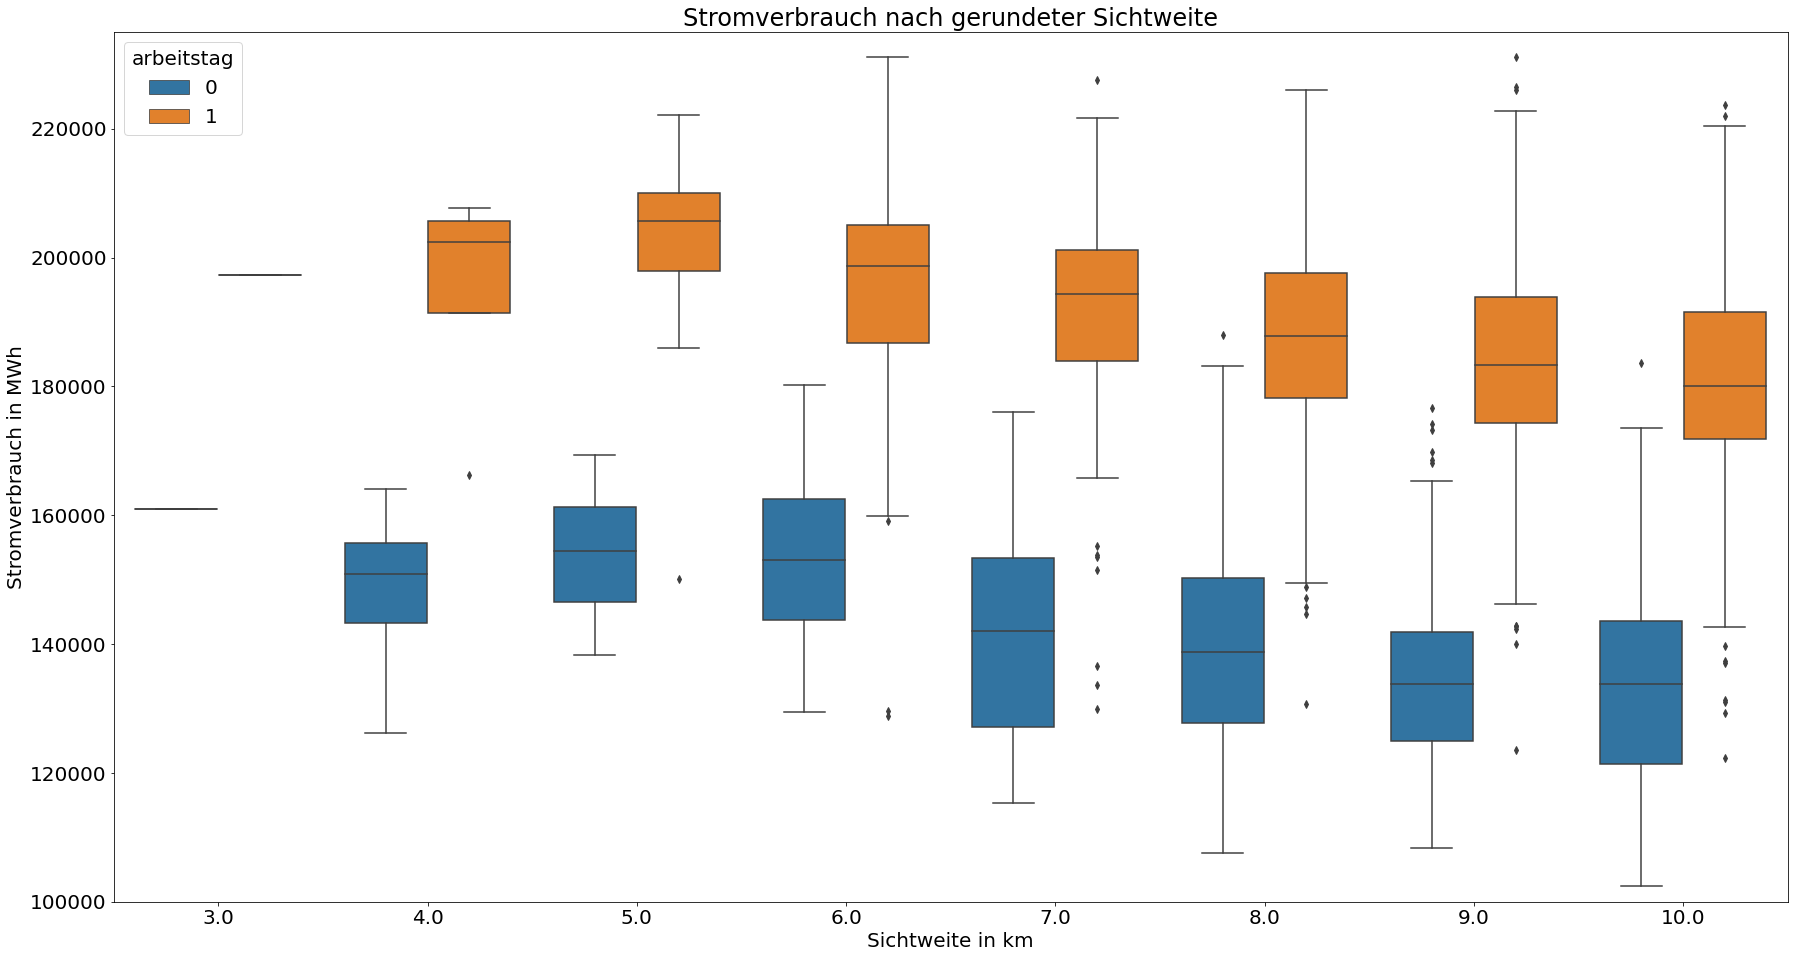

In [10]:
#Boxplot der gerundeten Sichtweite an Arbeitstagen erstellen
sns.boxplot(data=df, x="sichtweite_gerundet", y="verbrauch", hue="arbeitstag")

#Achsen und Layout
plt.title("Stromverbrauch nach gerundeter Sichtweite")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.xlabel("Sichtweite in km")

plt.show()

## <font size="6">Stromverbrauch nach Sichtweite und Monat (Boxplot)</font>

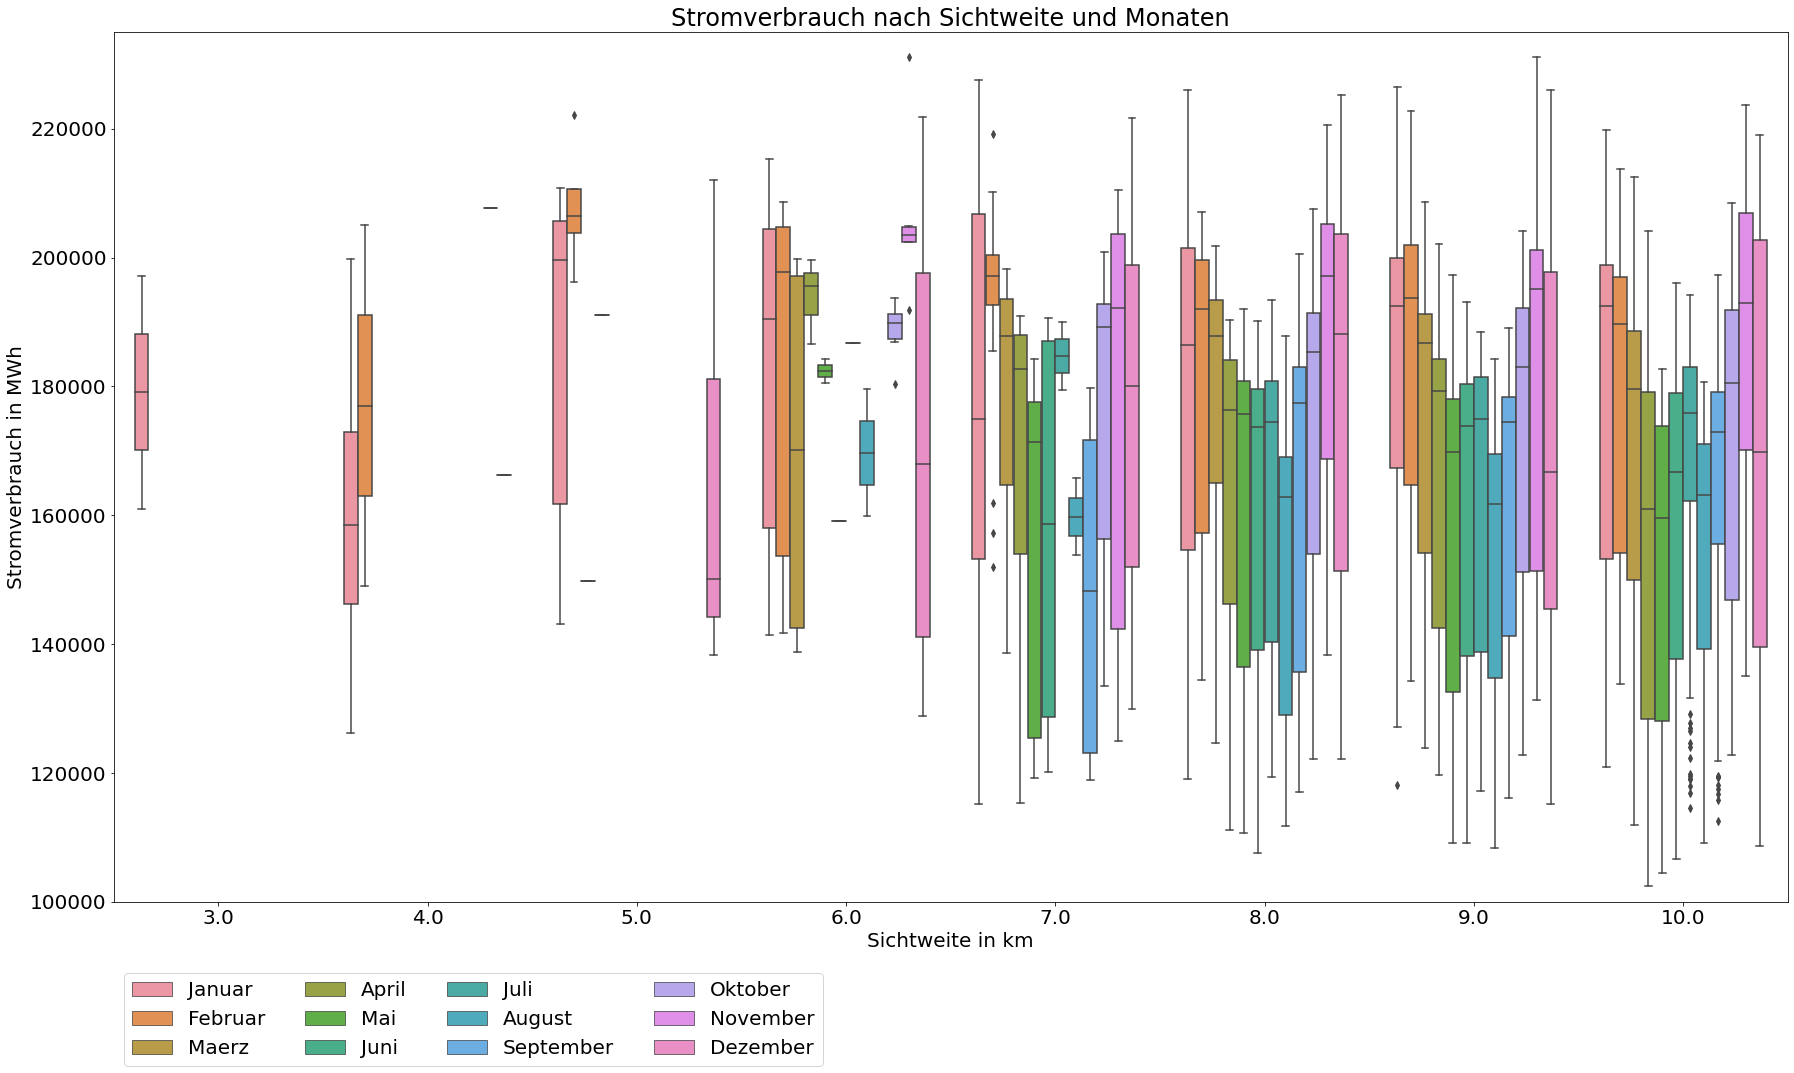

In [16]:
#Boxplot der gerundeten Sichtweite an Arbeitstagen erstellen
sns.boxplot(data=df, x="sichtweite_gerundet", y="verbrauch", hue="monat")

#Achsen und Layout
plt.title("Stromverbrauch nach Sichtweite und Monaten")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.xlabel("Sichtweite in km")

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

plt.show()

# <font size="7">Regressionsanalyse</font>

<font size="5">Durch die Regressionsanalyse wird geprüft, inwieweit sich der Verlauf des Stromverbrauchs anhand der verfügbaren exogenen Merkmale modellieren lässt. Es geht dabei noch nicht um die Erstellung eines Vorhersagemodells. Stattdessen wird die Regressionsanalyse eher mit Blick auf potenzielle Zusammenhänge, Korrelationen und Muster beziehungsweise generelle Verläufe durchgeführt. Aus diesem Grund bietet sich eine Funktion sechsten Grades an. Dafür wird mit den Daten von 2015 bis 2018 und den entsprechenden Merkmalen eine Regression sechsten Grades durchgeführt, welche dann mit den Daten für 2019 getestet wird. Wie bereits erwähnt, gibt es 2020 und 2021 Abweichungen vom ansonsten üblichen Verlauf. Daher werden nur die Daten bis einschließlich 2019 verwendet.</font>

## <font size="6">Regression mit Windgeschwindigkeit</font>

<font size="5">Es lässt sich zwar bis hierhin vermuten, dass es einen Zusammenhang zwischen dem Stromverbrauch und der Sichtweite gibt, allerdings kann das Regressionsmodell keine Informationen aus den Daten ziehen. Das Modell ist ähnlich schlecht wie beispielsweise bei der Windgeschwindigkeit oder der Luftfeuchtigkeit. Es lässt sich nicht einmal die jährliche Saisonalität erfassen.</font>

            verbrauch  sichtweite
datum                            
2015-01-01   126197.0         4.2
2015-01-02   147085.0         8.1
2015-01-03   141426.0         6.5
2015-01-04   132446.0         7.4
2015-01-05   152611.0         9.2
...               ...         ...
2019-12-27   129551.0         5.7
2019-12-28   125395.0         9.5
2019-12-29   121331.0        10.0
2019-12-30   137130.0        10.0
2019-12-31   131060.0        10.0

[1826 rows x 2 columns]
       Vorhersage
R2           -0.0
MAE       21736.0
MSE   706371004.0
RMSE      26577.6
                 
MAPE       14.6 %


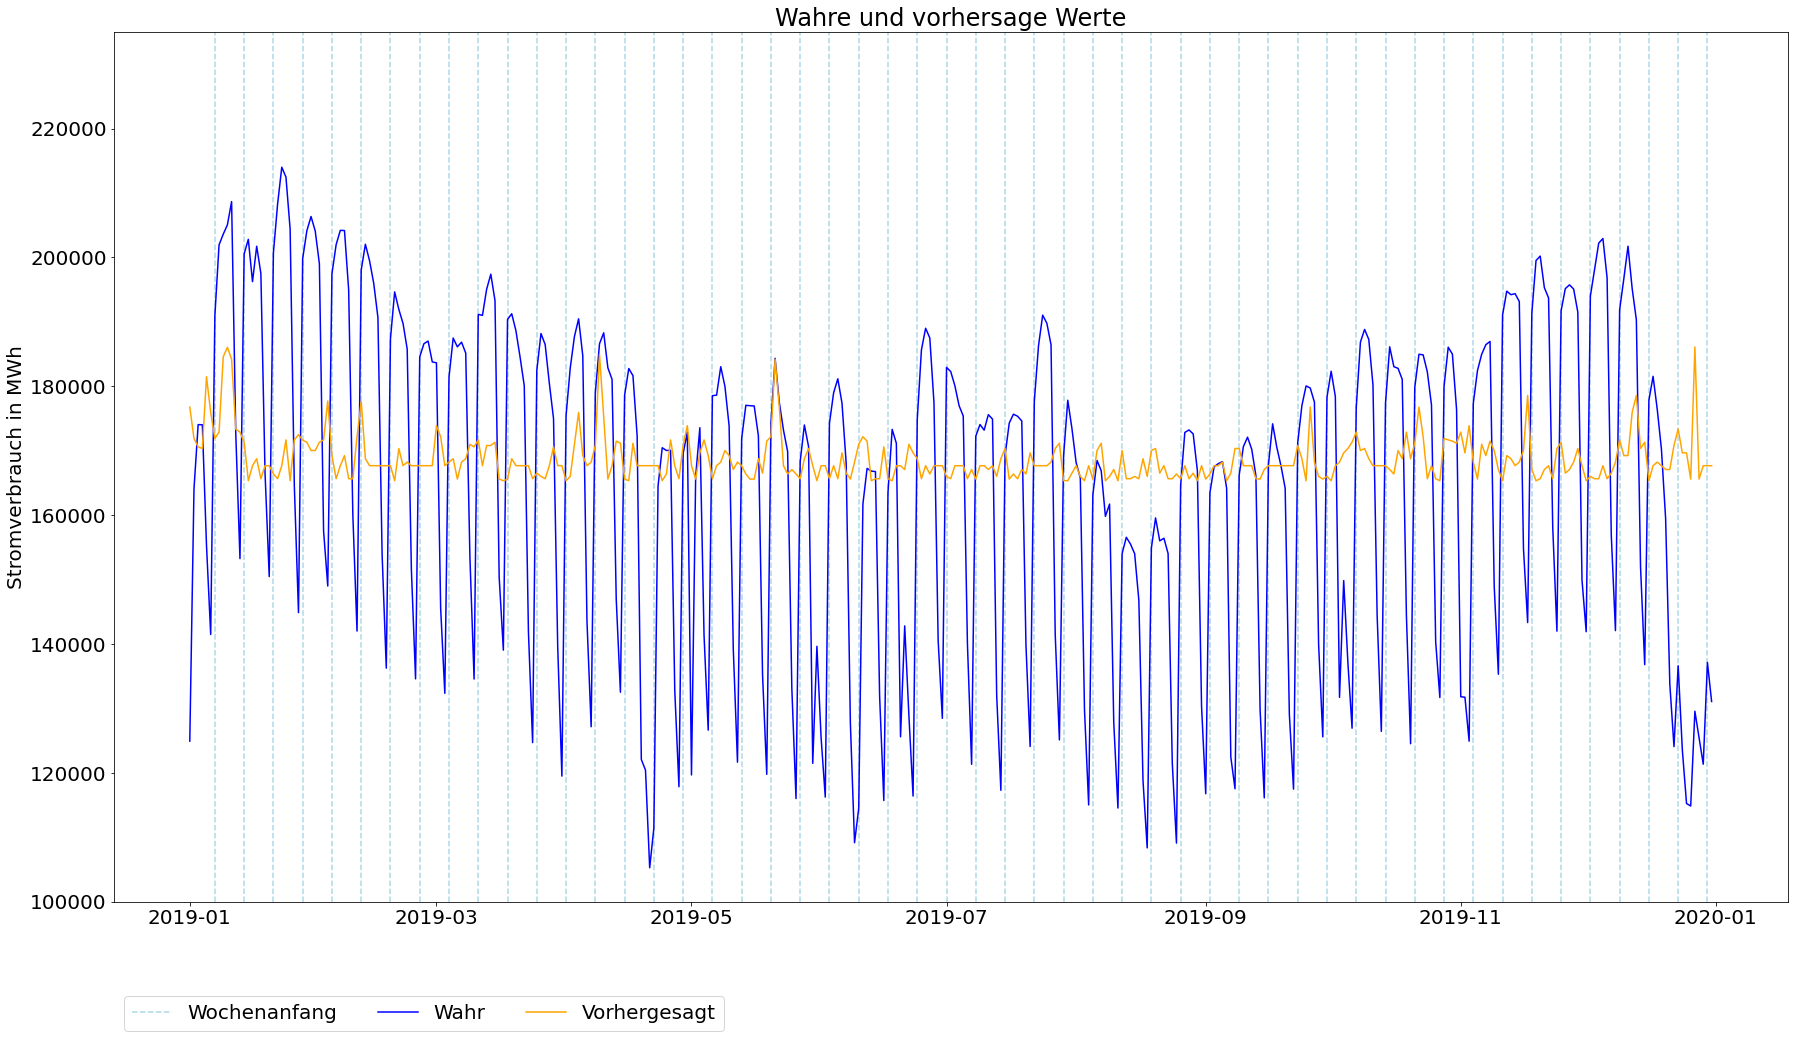

In [13]:
#Für Regression relevante Daten herausfiltern
df_regression = pd.DataFrame(data=[df["verbrauch"], df["sichtweite"]])
df_regression = df_regression.transpose()
df_regression = df_regression["2015-01-01":"2019-12-31"]

print(df_regression)

#Aufteilen in Trainings- und Testdaten
train, test = functions.train_test_split(df_regression, 365)

#Erstellen der polynomialen Merkmale
pf = PolynomialFeatures(degree=6)
pf = pf.fit(df_regression[["sichtweite"]].values.reshape(-1, 1))

#Aufteilung in X und y
y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train[["sichtweite"]])
X_test = pf.transform(test[["sichtweite"]])

#Regressionsmodell erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2019', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Vorhersagen auswerten
functions.custom_metrics(y_test, preds)

## <font size="6">Regression mit Arbeitstag und Windgeschwindigkeit</font>

<font size="5">Wie auch bei anderen, wenig aussagekräftigen Merkmalen zeigt sich, dass auch in der Verbindung mit dem Arbeitstag keine neuen Informationen vom Modell erkannt werden können. Die hier generalisierten Informationen sind vollständig auf den Arbeitstag zurückzuführen.</font>

            verbrauch  arbeitstag  sichtweite
datum                                        
2015-01-01   126197.0         0.0         4.2
2015-01-02   147085.0         1.0         8.1
2015-01-03   141426.0         0.0         6.5
2015-01-04   132446.0         0.0         7.4
2015-01-05   152611.0         1.0         9.2
...               ...         ...         ...
2019-12-27   129551.0         1.0         5.7
2019-12-28   125395.0         0.0         9.5
2019-12-29   121331.0         0.0        10.0
2019-12-30   137130.0         1.0        10.0
2019-12-31   131060.0         1.0        10.0

[1826 rows x 3 columns]
       Vorhersage
R2            0.7
MAE       11579.7
MSE   223295744.4
RMSE      14943.1
                 
MAPE        7.4 %


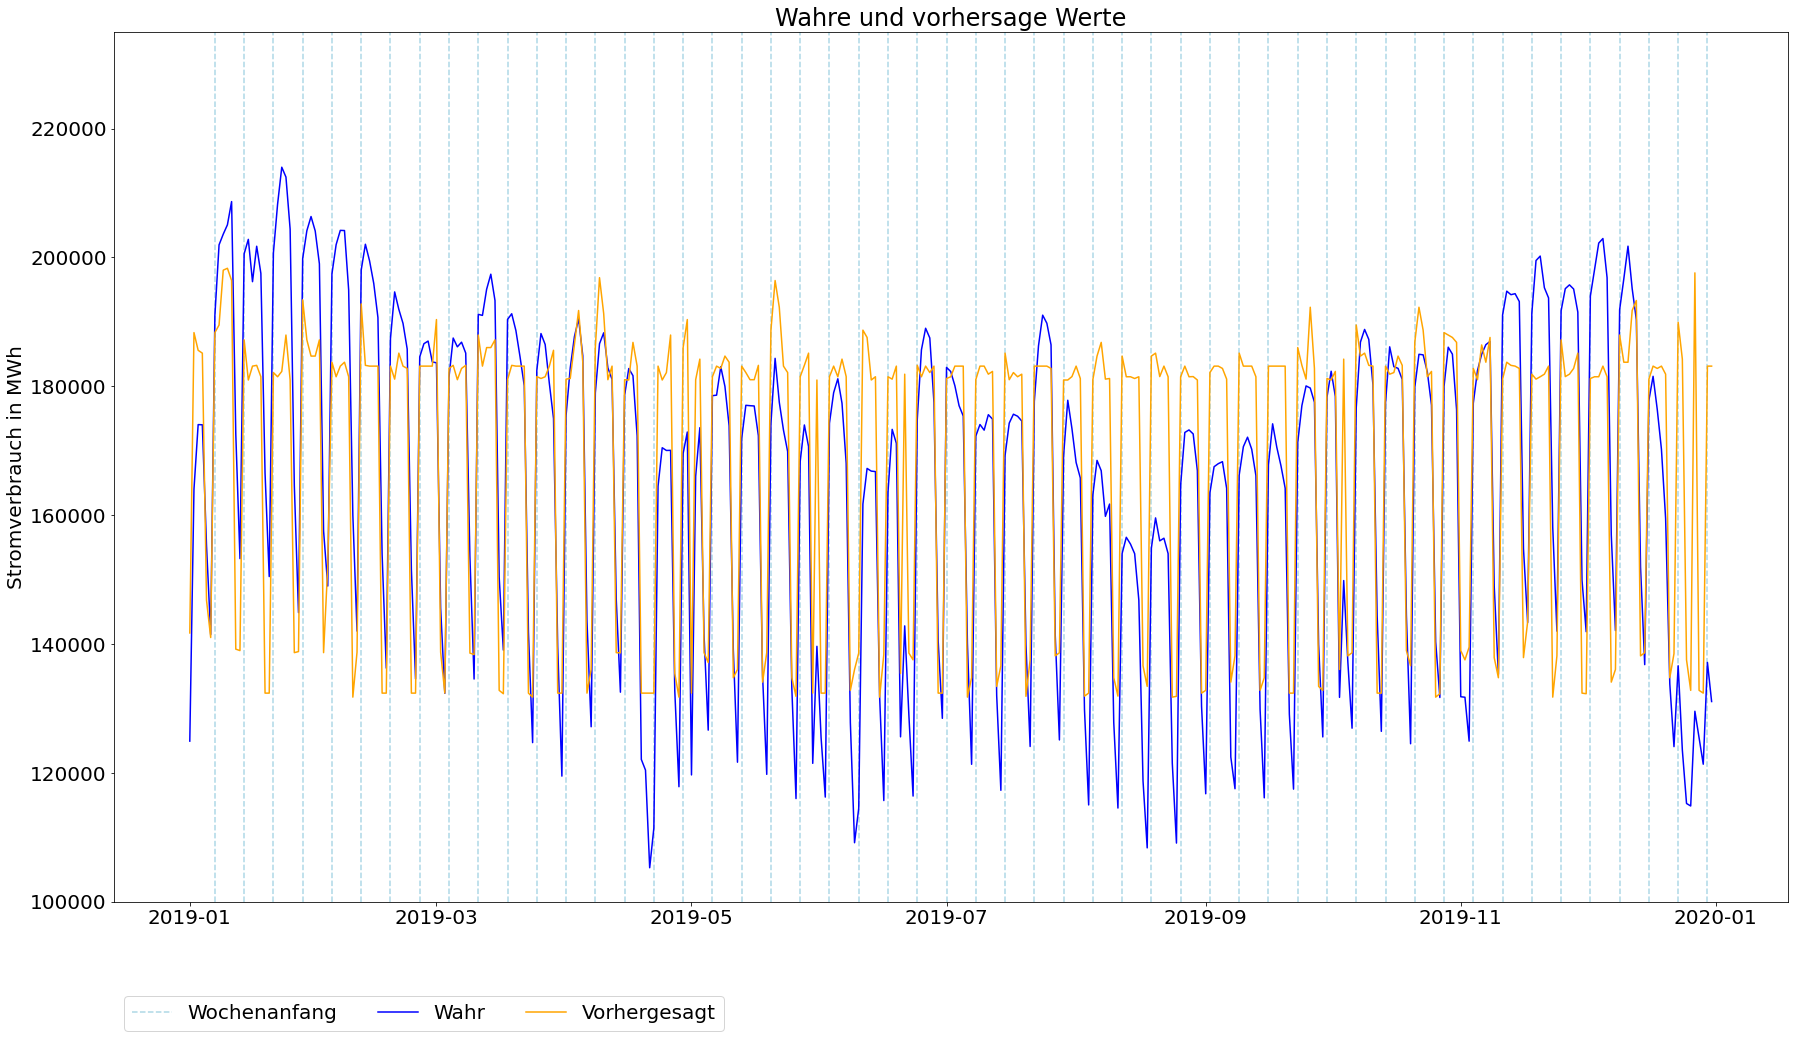

In [14]:
#Für Regression relevante Daten herausfiltern
df_regression = pd.DataFrame(data=[df["verbrauch"], df["arbeitstag"], df["sichtweite"]])
df_regression = df_regression.transpose()
df_regression = df_regression["2015-01-01":"2019-12-31"]

print(df_regression)

#Aufteilen in Trainings- und Testdaten
train, test = functions.train_test_split(df_regression, 365)

#Erstellen der polynomialen Merkmale
pf = PolynomialFeatures(degree=6)
pf = pf.fit(df_regression[["arbeitstag", "sichtweite"]].values.reshape(-2, 2))

#Aufteilung in X und y
y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train[["arbeitstag", "sichtweite"]])
X_test = pf.transform(test[["arbeitstag", "sichtweite"]])

#Regressionsmodell erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2019', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Vorhersagen auswerten
functions.custom_metrics(y_test, preds)

## <font size="6">Regression mit Arbeitstagen, Temperatur, Tagesstunden und Sichtweite</font>

<font size="5">Wir das Merkmal den übrigen, aussagekräftigen Merkmalen hinzugefügt, ergibt sich auch hier kein erkennbarer zusätzlicher Informationsgewinn.</font>

            verbrauch  tagesstunden  arbeitstag  temperatur  sichtweite
datum                                                                  
2015-01-01   126197.0           8.4         0.0        -2.5         4.2
2015-01-02   147085.0           8.4         1.0        -0.0         8.1
2015-01-03   141426.0           8.4         0.0         1.2         6.5
2015-01-04   132446.0           8.4         0.0        -0.2         7.4
2015-01-05   152611.0           8.4         1.0        -0.5         9.2
...               ...           ...         ...         ...         ...
2019-12-27   129551.0           8.3         1.0         5.1         5.7
2019-12-28   125395.0           8.3         0.0         1.7         9.5
2019-12-29   121331.0           8.3         0.0         1.1        10.0
2019-12-30   137130.0           8.3         1.0         2.8        10.0
2019-12-31   131060.0           8.3         1.0         3.2        10.0

[1826 rows x 5 columns]
       Vorhersage
R2            0.7
MAE

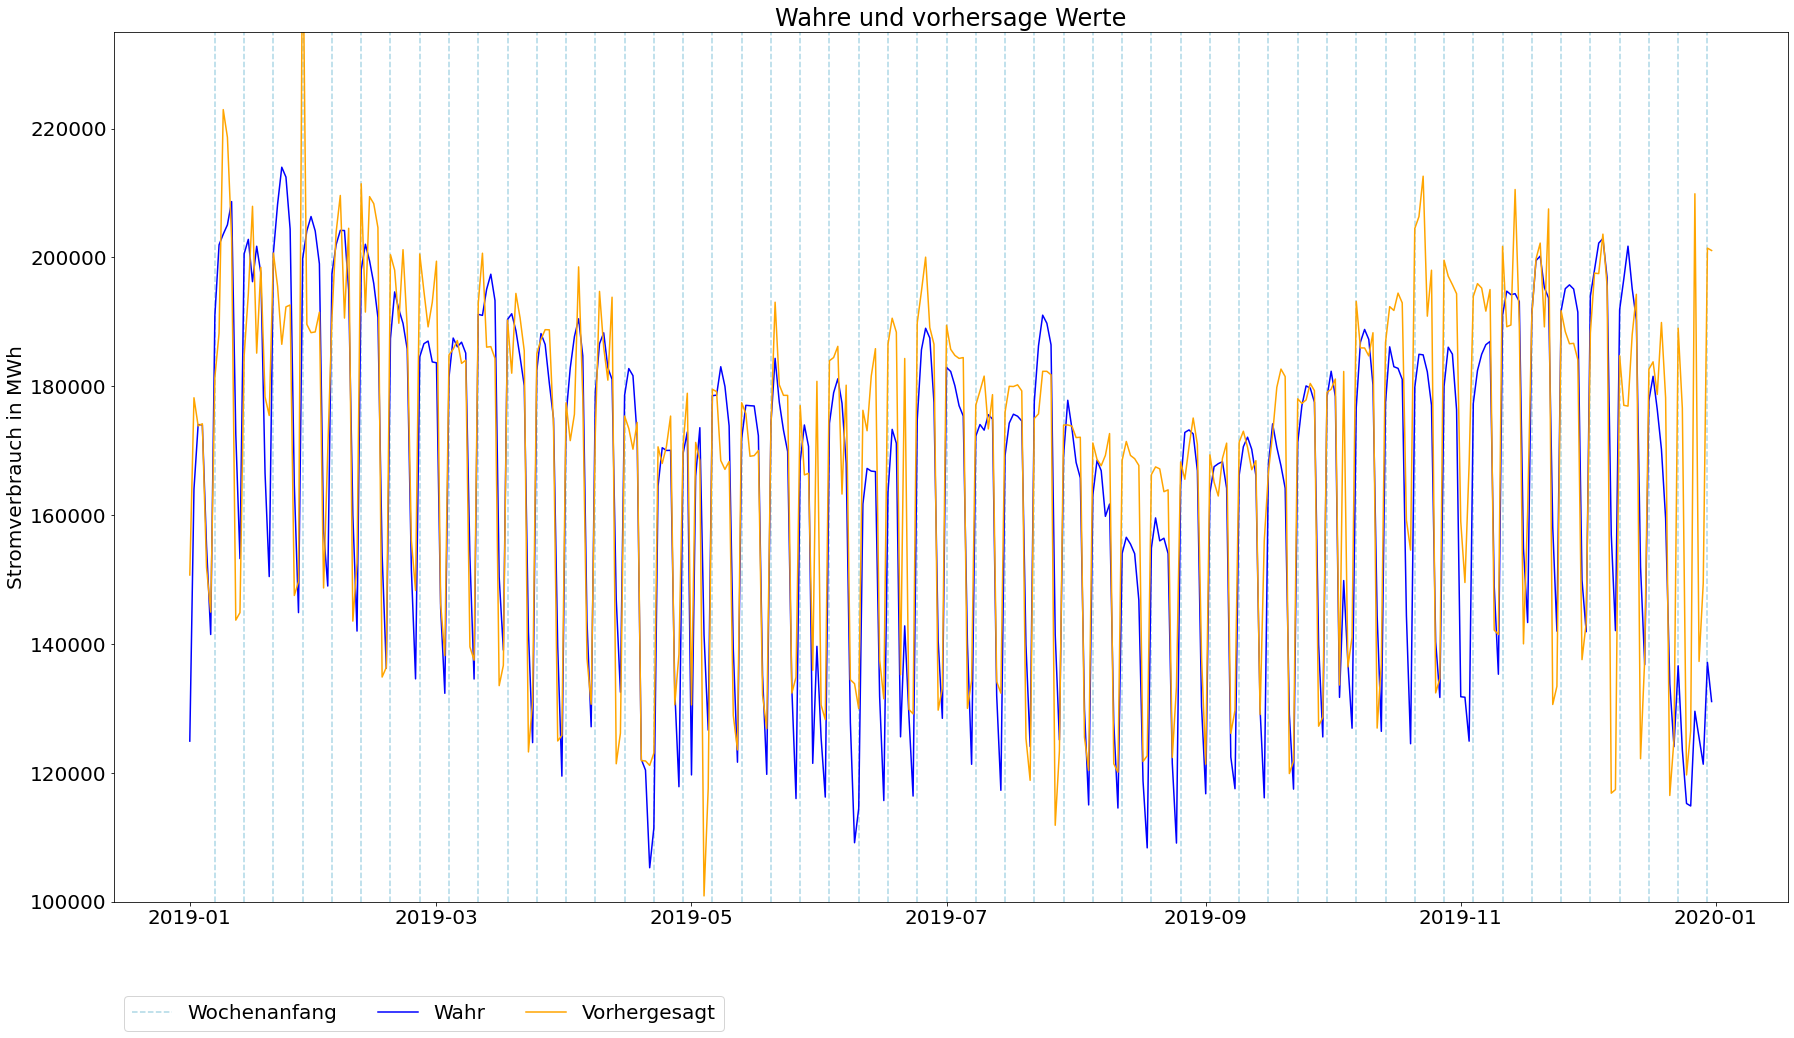

In [15]:
#Für Regression relevante Daten herausfiltern
df_regression = pd.DataFrame(data=[df["verbrauch"], df["tagesstunden"], df["arbeitstag"], df["temperatur"], df["sichtweite"]])
df_regression = df_regression.transpose()
df_regression = df_regression["2015-01-01":"2019-12-31"]

print(df_regression)

#Aufteilen in Trainings- und Testdaten
train, test = functions.train_test_split(df_regression, 365)

#Erstellen der polynomialen Merkmale
pf = PolynomialFeatures(degree=4)
pf = pf.fit(df_regression[["tagesstunden", "arbeitstag", "temperatur", "sichtweite"]].values.reshape(-4, 4))

#Aufteilung in X und y
y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train[["tagesstunden", "arbeitstag", "temperatur", "sichtweite"]])
X_test = pf.transform(test[["tagesstunden", "arbeitstag", "temperatur", "sichtweite"]])

#Regressionsmodell erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2019', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Vorhersagen auswerten
functions.custom_metrics(y_test, preds)

# <font size="7">Fazit</font>
<font size="5">Die Sichtweite lässt zwar zunächst einen Zusammenhang mit dem Stromverbruach vermuten, allerdings scheint dieser Zusammenhang sehr schwach und zumindest teilweise in anderen Effekten begründet. Jedenfalls scheint das Merkmal bei einer Regression keinen zusätzlichen Informationsgehalt zu liefern und wird daher nicht weiter verwendet.</font>